In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

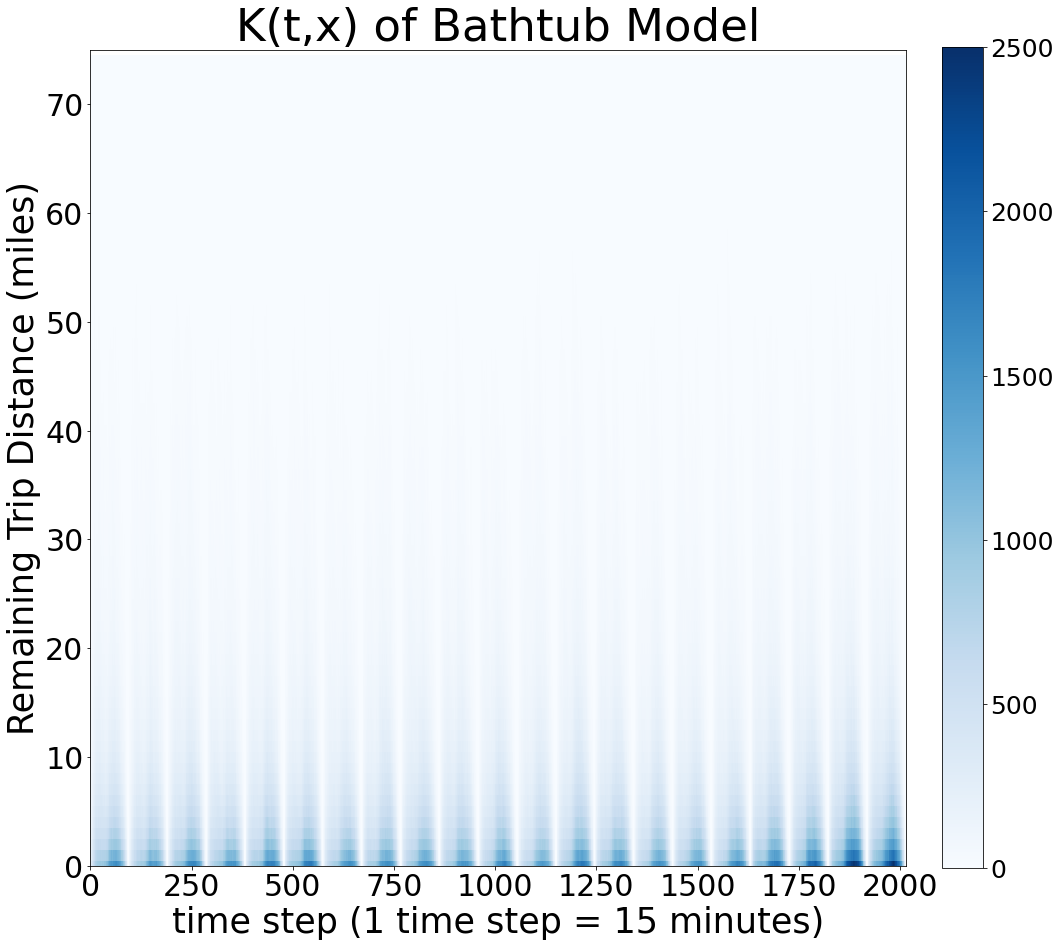

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.        , 0.02630273],
       [0.54054054, 0.8382134 ],
       [0.94594595, 0.23722084],
       ...,
       [0.47297297, 0.98957816],
       [0.06756757, 0.87394541],
       [0.54054054, 0.92704715]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,20,1]) 
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0106106135726599 0.020499147169859819 0.00072207997545998225 1.094987344545122
0.00871676663754074 0.016815756825459195 0.00061777644962228569 0.9942130926197345
0.0082129689623266829 0.015945817127707047 0.00048012079694631732 0.9681133706879108
0.0076127756471841453 0.014875761771078673 0.00034978952328961746 0.9349339100085612
0.0063274970287338335 0.012370804943251214 0.00028418911421645261 0.8522506202748397
0.0050780717394869309 0.0095699380059249585 0.000586205473048903 0.7524348814068055
0.0050162332544947579 0.0094108860721182838 0.00062158043687123173 0.7451718506403529
0.0049980414149178413 0.0093014665554599363 0.00069461627437574717 0.7403542796163705
0.0049845733856831243 0.0093066563977099344 0.00066249037365631418 0.7403886463504213
0.0049288019575987581 0.009188097835938493 0.00066950607925902344 0.7355972342345054
0.0047701501504242867 0.0089340869907955037 0.00060621331005306989 0.7248973993651476
0.0045999653482218152 0.0086127799265881717 0.00058715076985545861 0

0.003178708814386302 0.005441167625897067 0.00091625000287553658 0.5701457268949256
0.0031786676109558615 0.0054397990116835113 0.000917536210228212 0.5700856165844439
0.0031785889060617746 0.0054399888022044589 0.00091718900991909073 0.570108607852388
0.0031784738971863177 0.0054431131721441768 0.00091383462222845819 0.5702835061169055
0.0031782988771160282 0.0054482890759072807 0.00090830867832477583 0.5705576454309512
0.0031779616034558326 0.0054570290926981456 0.00089889411421351974 0.5710084230938639
0.0031776764145589617 0.0054637894857765459 0.0008915633433413772 0.571353355436994
0.0031772591168650836 0.0054626652575632878 0.00089185297616687915 0.5712630560484837
0.0031769491271292803 0.0054568129667772487 0.00089708528748131213 0.5709664027071605
0.003176699765329259 0.00544683258628433 0.00090656694437418793 0.5704764628965808
0.0031766287812723319 0.0054392669076926189 0.00091399065485204482 0.5700748282549731
0.0031765263631749721 0.005441211238183568 0.0009118414881663761

0.0031622480514977031 0.0054331170602848842 0.00089137904271052216 0.5694935524870736
0.0031619229386403787 0.0054250006452891764 0.00089884523199158111 0.5690970412594075
0.0031615915528200329 0.0054199506633338182 0.00090323244230624763 0.568859421049517
0.0031607697663934356 0.0054046410299552431 0.000916898502831628 0.5680815568419806
0.003160340365817302 0.0053869772248749054 0.00093370350675969869 0.5672471075868553
0.0031588024561390415 0.0053891956564578866 0.00092840925582019656 0.5672784557516125
0.0031584106804140432 0.005400047933603761 0.00091677342722432564 0.5677938757237325
0.0031580161099599349 0.0054102837018070926 0.00090574851811277713 0.5683094732071858
0.0031577198286196432 0.005412521024208505 0.00090291863303078128 0.568395069666334
0.0031574670578859575 0.0054148205467133646 0.00090011356905855052 0.568511394987796
0.0031570754713445785 0.0054115324825091014 0.00090261846018005552 0.5683334023377075
0.0031561837112983478 0.0054052236977752835 0.0009071437248214

0.0030647688219786404 0.0052855305850400035 0.00084400705891727712 0.5612934430548058
0.0030646447517646354 0.0052823904983324106 0.00084689900519685989 0.561146031639786
0.0030645027025346548 0.005282714220517775 0.00084629118455153442 0.561172019191259
0.0030642125838964019 0.0052798198062507552 0.00084860536154204836 0.5610280511563075
0.0030637006554427785 0.0052784544271915739 0.00084894688369398306 0.560958187079164
0.0030634450559784941 0.0052818954111892094 0.00084499470076777894 0.5611212386867598
0.0030633976452641484 0.0052803622864211084 0.00084643300410718872 0.5610412128723503
0.0030633060057722885 0.0052811636651634124 0.0008454483463811648 0.5610720747530454
0.0030632712142563694 0.0052807701280340345 0.00084577230047870394 0.5610506459403718
0.0030632260288625279 0.0052778349405195688 0.00084861711720548671 0.5609018979458636
0.0030631833246649444 0.0052779194877664044 0.0008484471615634846 0.5609252134601339
0.003063157621481244 0.005277079229364658 0.0008492360135978

0.0030584916455620808 0.0052756377107587788 0.00084134558036538256 0.5606966701138532
0.0030584500075182116 0.0052758292343578093 0.000841070780678614 0.5607150868380313
0.0030583460774842347 0.005274085524753459 0.0008426066302150108 0.5606125252786189
0.0030582433470397481 0.0052741196447676835 0.00084236704931181213 0.5606146576651615
0.0030581650645327791 0.0052727123513229392 0.00084361777774261885 0.5605503269885981
0.00305813335599281 0.0052731650639175663 0.00084310164806805394 0.560570846748921
0.0030581020079879771 0.005275085172918967 0.00084111884305698714 0.5606762067403441
0.0030580662018713347 0.005275852687929539 0.00084027971581313032 0.5607210286906402
0.00305803654275988 0.005277557283316559 0.000838515802203201 0.5607971023482311
0.0030579917844938075 0.0052764189913088134 0.0008395645776788016 0.5607420669910258
0.003057943951374026 0.0052763097515128171 0.00083957815123523538 0.5607301488021752
0.0030578833110144355 0.0052758296957626533 0.00083993692626621813 0.5

0.003049284361809344 0.0052430382409019228 0.00085553048271676539 0.5589891525379154
0.003049154969513382 0.0052449478973853082 0.00085336204164145589 0.559086594242563
0.0030489557238900784 0.0052490904920873983 0.00084882095569275835 0.5592823952833675
0.0030487703249433575 0.0052415682851937396 0.00085597236469297567 0.5588701170970239
0.003048532934895497 0.0052424029603686095 0.00085466290942238425 0.5589094541655206
0.0030481734492964351 0.0052375712471657261 0.00085877565142714366 0.5587047324390298
0.0030475375401576724 0.0052388581547084629 0.000856216925606882 0.5587710236463932
0.0030470666726899222 0.0052481262589957256 0.00084600708638411847 0.5592685746841154
0.0030466427100419324 0.005243498350410671 0.00084978706967319339 0.5590243073668458
0.0030459738894855928 0.0052343986673498467 0.00085754911162133911 0.558509270200298
0.0030456307209505646 0.0052410066035492664 0.00085025483835186291 0.558858192566477
0.0030452458933548942 0.0052308811746751976 0.00085961061203459

0.003030455068309059 0.0051949876309092475 0.00086592250570887081 0.5566509042732466
0.0030303322336643649 0.005197275664353092 0.00086338880297563789 0.5567780451389358
0.0030299606848345731 0.0051927669456402663 0.00086715442402888012 0.5564956709187308
0.0030295552509246853 0.0051972489461000028 0.000861861555749368 0.5567641385080404
0.0030291307471465292 0.0051886274288055157 0.00086963406548754257 0.5563397571730588
0.0030288712793097913 0.0051839364416291969 0.00087380611699038534 0.5560696780775319
0.0030288101634502896 0.0051800767681357942 0.00087754355876478525 0.5559787887517348
0.0030285165624331896 0.0051805373723803165 0.00087649575248606231 0.555911976937299
0.0030284184547767468 0.0051830485542371119 0.00087378835531638148 0.5560608627589094
0.0030283014650444094 0.0051823881059384807 0.00087421482415033847 0.5560283337832945
0.0030280564479021875 0.0051795557982818119 0.0008765570975225633 0.5558923544193061
0.00302794181434265 0.0051828322651279613 0.0008730513635573

0.0030129842287023997 0.0051338074086034512 0.00089216104880134788 0.5533881941380124
0.003012845056227011 0.005135368558625412 0.00089032155382861016 0.5534774164181154
0.0030125962076881169 0.005134656115045229 0.00089053630033100436 0.5534692876428532
0.0030123886340850817 0.0051313619456415252 0.00089341532252863807 0.5533058705972496
0.0030122281047277768 0.0051244072014667037 0.00090004900798885024 0.5529580025049458
0.0030121183327474549 0.0051290878179575854 0.00089514884753732419 0.5532200769307581
0.0030119793887933848 0.0051300758912893084 0.00089388288629746113 0.5532792108471883
0.0030116845930463643 0.0051337643243078547 0.00088960486178487383 0.5534767546876356
0.0030114766123775917 0.0051360743038870562 0.000886878920868127 0.5535816852335809
0.0030113151070569597 0.0051372614754246378 0.00088536873868928149 0.5536400090642918
0.0030111719824233345 0.0051382933486441591 0.00088405061620251 0.5536895001259472
0.0030111427531571669 0.0051358053639976586 0.0008864801423166

0.0029961955083135589 0.005102123263448808 0.0008902677531783099 0.5517142874895139
0.0029959595783299381 0.0051002785712716105 0.00089164058538826528 0.5516227054499808
0.0029958111907101709 0.0051004048447469757 0.00089121753667336593 0.5516181829325677
0.0029956152686398444 0.0050983091619393288 0.00089292137534036033 0.5515042092740475
0.0029954546374586733 0.00509582330055517 0.00089508597436217655 0.5513368082496322
0.0029953850944297476 0.0050984354787948485 0.00089233471006464678 0.5514649431439768
0.0029952580071241413 0.0050944813982514523 0.00089603461599683078 0.5512739988890331
0.0029951781050576573 0.0050936777580161711 0.00089667845209914375 0.5512132327404967
0.0029951090531860074 0.0050899730739169206 0.00090024503245509431 0.5510203607162981
0.0029950014606303079 0.0050922568796969731 0.00089774604156364287 0.551129485132147
0.0029948390810596395 0.0050920910399182536 0.0008975871222010257 0.5511026024746344
0.0029945363798174968 0.0050908895446160583 0.00089818321501

0.0029871347041341791 0.0050872674693987806 0.00088700193886957746 0.5506911891316905
0.002987121118303905 0.00508757083262801 0.00088667140397979982 0.55070243829987
0.0029870839562807835 0.0050884019378768181 0.00088576597468474866 0.5507456437236904
0.0029870323846367891 0.0050901086881651857 0.00088395608110839244 0.550835684125696
0.0029869462228782014 0.0050904771255801153 0.00088341532017628763 0.5508618889216944
0.0029867839959765953 0.0050929684427538707 0.00088059954919932017 0.5510209660890786
0.0029866089565620249 0.0050896593013024065 0.000883558611821643 0.5508695004201764
0.0029865039445988264 0.0050931085852149388 0.00087989930398271363 0.5510608954796098
0.0029864445484093609 0.0050930858159844092 0.00087980328083431291 0.5510538351024414
0.0029863248323811968 0.0050848101197271123 0.00088783954503528109 0.5506162036396659
0.0029861978703342785 0.0050840805499352626 0.00088831519073329448 0.5505637552119884
0.0029860997216748239 0.0050826715509469178 0.0008895278924027

0.0029808396235050127 0.0050737214920459272 0.00088795775496409816 0.5501896877587713
0.00298081596929276 0.005074358445439426 0.000887273493146094 0.5502363975096709
0.0029807874089424089 0.005073868319727815 0.00088770649815700289 0.550215150414444
0.0029807527382759219 0.0050734459529116743 0.0008880595236401696 0.550197342281183
0.0029807093169286671 0.00507293463656393 0.00088848399729340424 0.5501622428886271
0.0029806417367934778 0.0050734249702429086 0.00088785850334404694 0.5501871214396711
0.0029805503521409872 0.0050723875205255309 0.0008887131837564434 0.5501405434004817
0.0029805143826094342 0.0050720784150438116 0.00088895035017505671 0.5501116145223954
0.0029804685538107811 0.0050719627450377417 0.00088897436258382066 0.5501290249985893
0.0029804274579865574 0.0050715311947782289 0.00088932372119488606 0.5501016695276069
0.00298038871483665 0.0050700613011997854 0.00089071612847351454 0.5500246074826494
0.0029803421364392813 0.0050705445538592906 0.00089013971901927193 0

0.0029732444190065377 0.0050656287239118332 0.00088086011410124258 0.549905371221133
0.0029729391018872022 0.0050686042525330561 0.000877273951241348 0.5500895508885391
0.0029726444518821207 0.0050619732519936013 0.00088331565177063981 0.5497783603792115
0.0029724022509111056 0.005074054089746898 0.00087075041207531321 0.5504402907609167
0.0029720681680921995 0.0050573522569038387 0.00088678407928056058 0.549556969530101
0.0029719246132810318 0.0050584582943783846 0.00088539093218367867 0.5496355029068263
0.0029717607701309711 0.0050655459050194668 0.00087797563524247518 0.5499986415414404
0.0029715700808024209 0.0050624088324627819 0.00088073132914205979 0.5498344189426326
0.0029714731987513406 0.0050557467415108014 0.00088719965599187961 0.5495069490953762
0.0029713203507122938 0.0050555542302752931 0.00088708647114929442 0.5494991959946388
0.0029712115067202366 0.0050605911976257835 0.00088183181581468937 0.5497941122674012
0.0029710291959229385 0.0050592933043492744 0.0008827650874

0.0029558654262388318 0.0050050780960951531 0.00090665275638251086 0.5467806104641889
0.002955615266091431 0.0050053447429761876 0.00090588578920667456 0.5467564100241743
0.0029554816596168835 0.0050093040064162347 0.00090165931281753237 0.5469909848439453
0.0029554084879788835 0.0050069092257539194 0.00090390775020384785 0.5468847007525349
0.0029552587642264505 0.00500474494801099 0.00090577258044191079 0.5467585032414717
0.0029551927509839206 0.0050068932564092273 0.00090349224555861358 0.5468701781706432
0.0029551215169596103 0.0050066043881094183 0.00090363864580980224 0.5468561312237881
0.00295495187081702 0.0050042141220901174 0.00090568961954392234 0.5467319011235074
0.0029548477791459405 0.0050015905541430181 0.00090810500414886287 0.5466106090866079
0.0029547177927498228 0.0049993250708925486 0.00091011051460709728 0.5464918745289089
0.0029545689528320883 0.0049964108866848139 0.000912727018979363 0.5463340187969197
0.0029544895583548886 0.0049979645520953266 0.000911014564614

0.0029397359636481914 0.0049805814364302457 0.00089889049086613751 0.5451702627618219
0.0029395975768075739 0.0049781825088711261 0.00090101264474402192 0.5450446664163022
0.0029394718217335891 0.004968742464898368 0.00091020117856881037 0.5445274020566503
0.002939327872964019 0.0049697278403321582 0.00090892790559587956 0.5445855538953774
0.002939158149750697 0.0049691464913166556 0.00090916980818473814 0.5445631012718888
0.0029389629336672414 0.0049712267824418921 0.00090669908489259086 0.5446853494951228
0.0029389038356765784 0.0049715235795105856 0.00090628409184257146 0.544712570905434
0.0029387586355853787 0.0049713507379638179 0.00090616653320693978 0.5446947460480512
0.002938681739658906 0.0049678903345334912 0.00090947314478432076 0.5445029536375697
0.0029385494941441314 0.0049669623514827423 0.00091013663680552083 0.5444504183549537
0.00293841305580843 0.0049640906528792394 0.00091273545873762029 0.5443084983219569
0.0029382912696813246 0.0049638952092302376 0.000912687330132

0.0029026887066282451 0.0049344768565572454 0.00087090055669924516 0.5430136976068813
0.0029024052598571174 0.0049335000923428152 0.00087131042737141954 0.5429814001813634
0.0029021175309525186 0.004936064995381865 0.00086817006652317177 0.5431405267870851
0.002901918901881715 0.0049363208121128727 0.00086751699165055706 0.5431762861622704
0.0029017641933950819 0.0049372623029159991 0.00086626608387416464 0.5432207204969906
0.00290165539033079 0.0049371555180053516 0.00086615526265622844 0.5432141594799532
0.0029014510486691 0.0049346619506624037 0.000868240146675797 0.5430733530724858
0.0029011749825681196 0.0049361161948134388 0.00086623377032280023 0.5431468652143278
0.0029010725377432481 0.0049312258288247337 0.0008709192466617629 0.5428624953607205
0.0029008992071699082 0.0049326432144205668 0.00086915519991924938 0.5429850701468637
0.0029007747755626827 0.0049369569273294807 0.000864592623795885 0.5432087182015681
0.0029006665637135586 0.0049364565386262327 0.00086487658880088445

0.0028866376484153735 0.0049178583286852047 0.0008554169681455428 0.5423311646378666
0.0028866084747881161 0.0049172268126305707 0.00085599013694566167 0.5422940565086407
0.002886574022565255 0.0049164976930315858 0.00085665035209892449 0.5422660734979073
0.0028865513886108998 0.0049163548136742837 0.00085674796354751623 0.5422653055738691
0.0028865081416084384 0.0049173634387755455 0.00085565284444133114 0.5423254790921749
0.0028864802061652818 0.0049161505283746793 0.00085680988395588455 0.5422341667137045
0.0028863833016095578 0.0049197350264514527 0.0008530315767676629 0.5424447469021224
0.0028862973237149549 0.0049205016830094163 0.0008520929644204937 0.5424722759975297
0.0028861444472885085 0.00491881469722981 0.00085347419734720716 0.5423693083560501
0.0028859993400129247 0.00491722879695712 0.00085476988306872894 0.5422574055810283
0.0028858628426990654 0.0049158541945883054 0.00085587149080982509 0.5421670379514817
0.0028857509794847562 0.0049155117710880337 0.0008559901878814

0.0028800709797545507 0.004899949624490329 0.00086019233501877267 0.5414464722135127
0.0028799688849193298 0.004901149046255303 0.00085878872358335662 0.5415174007244975
0.0028798796577684366 0.00490251927016364 0.0008572400453732336 0.5415931340564376
0.00287973160776886 0.0049044614379715 0.00085500177756621994 0.5417224384969294
0.0028795859368385061 0.0049107091065224021 0.00084846276715461037 0.5420562331575497
0.0028794885058374695 0.0049069593306070546 0.00085201768106788432 0.5418964653243834
0.002879391496149397 0.0049095928912356842 0.00084919010106310959 0.5420200438763205
0.0028793535860585744 0.0049061374477271883 0.00085256972438996041 0.5418479510853439
0.0028792481759069761 0.0049072234947808227 0.00085127285703312972 0.5418735826828825
0.0028791898411547781 0.0049066680204960522 0.000851711661813504 0.5418534323692508
0.0028791165467467704 0.0049062479500106247 0.000851985143482916 0.5418473774355673
0.0028790302098830119 0.0049061335014521333 0.00085192691831389035 0.

0.0028695487772773236 0.0049016989632906247 0.00083739859126402227 0.5413727957120227
0.0028694502046549249 0.0049018396765025118 0.00083706073280733807 0.5413796102875863
0.002869275523864484 0.0049016069455416192 0.00083694410218734859 0.5413555715121717
0.0028691816053427054 0.0048992980229838482 0.00083906518770156236 0.5412347871348391
0.0028690102685254696 0.0048991336125712021 0.00083888692447973718 0.5411853093181535
0.0028689407089551931 0.0048955026953757582 0.000842378722534628 0.5409545170060326
0.002868856342691223 0.004897132389152444 0.00084058029623000239 0.5410491353206012
0.0028687678633472066 0.0048947941764309784 0.0008427415502634349 0.5409337218263734
0.0028687134498662989 0.0048939040860852883 0.00084352281364730923 0.5408693180692723
0.0028686643974047722 0.0048921913072092066 0.00084513748760033742 0.5407678022803039
0.0028685951949991503 0.0048916992036223267 0.0008454911863759742 0.5407297614877861
0.0028685400042574956 0.0048903045071524856 0.000846775501362

0.0028613254637891257 0.0048703651471848942 0.00085228578039335686 0.5394328028599509
0.0028612828324194885 0.0048683626346649276 0.00085420303017404967 0.5393124015602239
0.00286122584225964 0.0048648024960048063 0.000857649188514473 0.5391110579959582
0.0028611655320714439 0.0048618122829638564 0.0008605187811790314 0.538930316831909
0.0028610898939262146 0.0048609156909362565 0.00086126409691617283 0.5388936086325609
0.0028610198609530912 0.0048618872206970315 0.00086015250120915067 0.538949089091473
0.0028609200716889762 0.0048616722968742327 0.00086016784650371977 0.5389171836316579
0.0028608232453694316 0.0048611976636693775 0.00086044882706948569 0.5388865725736275
0.0028607300617703581 0.0048594880309808276 0.00086197209255988827 0.5387918102321202
0.002860659958882877 0.0048559831552956205 0.00086533676247013366 0.5385790260109582
0.0028605734657877547 0.0048543945217144231 0.00086675240986108576 0.5384843016825033
0.0028604409547392769 0.0048518420965133905 0.0008690398129651

0.0028460769227213953 0.0048332522097360546 0.00085890163570673554 0.5370912764779098
0.0028458870855141813 0.0048326662769807927 0.00085910789404756961 0.5370999803752183
0.002845804540666904 0.0048329995840939426 0.00085860949723986569 0.5371153821690648
0.0028456942836590409 0.0048310147422408779 0.00086037382507720426 0.5369928948008191
0.0028456016346979575 0.00483098680825802 0.00086021646113789449 0.5369971563069769
0.0028454742435960749 0.0048262965289011805 0.00086465195829096939 0.5367385985355587
0.0028453263176979986 0.0048260557200004743 0.00086459691539552319 0.5367035478562059
0.0028450976445380952 0.0048257630556362121 0.00086443223343997822 0.5366702130320918
0.00284490942453282 0.0048228465364606671 0.00086697231260497265 0.5365023009032767
0.0028447976597998446 0.0048232397151952815 0.00086635560440440757 0.5365419519244644
0.0028447057641701121 0.004819330794803821 0.00087008073353640346 0.5362953034102848
0.002844608243002983 0.00482342437940682 0.00086579210659914

0.0028343783670466962 0.0048154367794073913 0.00085331995468600078 0.5362753212159528
0.0028342657999964778 0.0048122552398926132 0.00085627636010034266 0.5361214095528286
0.0028337530244502656 0.0048115294622906261 0.000855976586609905 0.5360414352540271
0.0028337400044763147 0.0048148005918857368 0.00085267941706689292 0.5362132431501722
0.0028333831614012744 0.00480957562262552 0.00085719070017702917 0.5359115276399765
0.0028332852913825809 0.0048109455984412632 0.00085562498432389836 0.5359979050550394
0.002833153021242978 0.0048105982784174091 0.00085570776406854708 0.5359810698987042
0.0028330271537121443 0.0048096847890155532 0.00085636951840873494 0.5359225248460561
0.0028329210294822937 0.0048093331965981942 0.00085650886236639375 0.535909733560495
0.0028327905512379116 0.00480865792824528 0.00085692317423054307 0.5358670958881568
0.0028326704309067211 0.0048063403481765432 0.00085900051363689914 0.5357168085951063
0.0028325709841097836 0.0048050697976087763 0.0008600721706107

0.0028258083268540321 0.0048033811401758707 0.00084823551353219368 0.5356729630193177
0.0028257073502350482 0.0048072330183890205 0.000844181682081076 0.535878679831464
0.0028256392555061636 0.0048054783317952217 0.000845800179217105 0.5357888091560311
0.0028255598339819083 0.0048071330683919439 0.00084398659957187275 0.5358811231352929
0.0028255087976128595 0.004805879195233822 0.000845138399991897 0.5358035726716809
0.0028254734190502197 0.0048059745378050229 0.00084497230029541607 0.5358220676194223
0.0028254279352105532 0.0048051318703897158 0.00084572400003139075 0.5357850486509206
0.002825363336335028 0.0048044470970653843 0.00084627957560467159 0.5357543047591387
0.0028252876488925279 0.0048056346504941052 0.00084494064729095074 0.5358128538808732
0.0028252101095550732 0.0048049000555369882 0.00084552016357315794 0.5357599975060542
0.0028251181949183837 0.0048111390506029462 0.00083909733923382107 0.5360832622041141
0.0028250583128618546 0.0048124470171884148 0.00083766960853529

0.0027944782082148364 0.0047189530805694475 0.00087000333586022532 0.531747396171992
0.002794318388324348 0.00471818758910453 0.00087044918754416588 0.5316793828856823
0.0027941295289987188 0.0047175923518934584 0.00087066670610397876 0.5316094906698593
0.0027940404484770322 0.0047135439599813251 0.00087453693697273917 0.5313750976744374
0.0027938994479081909 0.0047129654327005251 0.00087483346311585674 0.5313731771357186
0.002793734524609764 0.0047183765638555654 0.00086909248536396247 0.5316674132339572
0.0027934900509575976 0.0047208774482762539 0.00086610265363894147 0.5317804381737479
0.0027929973048792462 0.0047283813027496364 0.00085761330700885564 0.5321551164490743
0.0027925664154819793 0.0047275168394340789 0.00085761599152988006 0.5321086802125047
0.0027922094013474127 0.0047245214687645937 0.00085989733393023165 0.531979727161906
0.0027920935185805577 0.0047244637873536856 0.00085972324980742925 0.5320044159753528
0.0027920217411433667 0.0047232000467197456 0.00086084343556

0.0027747149332163572 0.0046898210670185134 0.000859608799414201 0.5303291257567996
0.0027745940769067011 0.0046874965657193023 0.00086169158809410015 0.5302282269311284
0.0027745054268662004 0.004687319584872382 0.00086169126886001849 0.5302198799754405
0.002774376250655955 0.0046898285660719975 0.00085892393523991236 0.5303785143454449
0.0027742710533707527 0.0046890265765480331 0.00085951553019347207 0.5303429232184464
0.0027741563825267393 0.0046875950176092631 0.00086071774744421567 0.5302787764280642
0.0027740745161808885 0.0046866920842485093 0.00086145694811326739 0.5302156935708079
0.0027739796167841266 0.0046837757754925038 0.00086418345807574913 0.530059531187945
0.0027739102479648484 0.0046830323075415237 0.00086478818838817313 0.5299974993385461
0.0027738464191305523 0.0046818987071430389 0.000865794131118066 0.529917688577271
0.0027738108609265196 0.0046814348915877914 0.00086618683026524806 0.529886459810409
0.002773754193825024 0.0046813542316085244 0.000866154156041523

0.0027677903840805122 0.0046588043298188718 0.00087677643834215262 0.5286061637932297
0.0027677497722227349 0.0046589961961241138 0.00087650334832135629 0.5286182454468991
0.0027677275525106572 0.0046594448078305858 0.00087601029719072861 0.5286578664766679
0.002767692546882181 0.0046599461929360316 0.00087543890082833009 0.528666416457255
0.0027676760248159294 0.0046594193839398015 0.00087593266569205709 0.5286407368455754
0.0027676707341603461 0.004659330870381383 0.00087601059793930927 0.528639817757389
0.0027676703011604224 0.0046591448782957248 0.0008761957240251201 0.5286328836824312
0.0027676527474287723 0.0046590295700765765 0.00087627592478096788 0.5286328616569982
0.0027676437711549621 0.0046587826534447239 0.00087650488886519993 0.5286238795001753
0.002767631796447673 0.0046583463468261579 0.00087691724606918842 0.5286093408394169
0.0027676288588991123 0.0046589226874230345 0.00087633503037518978 0.5286423348979006
0.0027676197491009963 0.0046580516208084774 0.00087718787739

0.0027643029061482026 0.0046594021022899569 0.00086920371000644874 0.5287361851428564
0.0027641804164766854 0.0046592326450643666 0.000869128187889004 0.528741363359746
0.0027641106670260622 0.0046594232678208881 0.00086879806623123637 0.5287437275338958
0.0027638894156033927 0.0046558089203998718 0.00087196991080691394 0.5285437033811855
0.0027635588613610026 0.0046514517828717874 0.000875665939850218 0.5283157369237531
0.0027632091530954157 0.0046455332490497828 0.00088088505714104806 0.5280049207752144
0.0027629429612821129 0.0046419777105928921 0.00088390821197133391 0.5278115804308241
0.0027626193341748276 0.00463633869898596 0.00088889996936369583 0.5275107140465914
0.0027623852008070581 0.0046360671262446066 0.00088870327536950955 0.5275312207882501
0.0027623130302737724 0.0046348789457024255 0.000889747114845119 0.5274754471366997
0.0027620801036684589 0.00463177044103759 0.00089238976629932841 0.5273380883290013
0.0027618599434129035 0.0046323196740451419 0.000891400212780665 

0.0027520533053782478 0.0046176714798909476 0.00088643513086554852 0.526617720528887
0.0027520297591812804 0.0046183510773217988 0.00088570844104076155 0.5266584642192959
0.0027519792402444132 0.0046197071023574123 0.00088425137813141449 0.5267602111836894
0.0027519442584620292 0.0046196811426027495 0.00088420737432130868 0.526757098123956
0.0027518706432936948 0.0046192590792494661 0.00088448220733792365 0.5267324421178586
0.0027518189836769412 0.0046194080833028483 0.00088422988405103392 0.5267318430472971
0.0027516739549881975 0.0046173710515054625 0.00088597685847093227 0.5266211710490037
0.0027515972059583131 0.0046179734026513394 0.00088522100926528662 0.5266422697600871
0.0027512753271912976 0.0046184217572164564 0.00088412889716613834 0.5266937177028242
0.0027509741028308942 0.0046169828717459206 0.00088496533391586776 0.5266581727071953
0.0027508668037358134 0.0046167985746212352 0.00088493503285039189 0.5266411048168418
0.0027507733634369322 0.0046181638712918371 0.0008833828

0.0027420336297090987 0.0046054752879026179 0.00087859197151557986 0.526040555579323
0.0027418657241052259 0.004606490893884695 0.00087724055432575711 0.5261013954139325
0.0027417325102453817 0.0046091501237057915 0.00087431489678497219 0.5262546877103002
0.0027416546974363023 0.00460990348254624 0.00087340591232636425 0.5263101698174922
0.0027415230039637335 0.0046085266640163037 0.00087451934391116358 0.5262546350657235
0.0027414095031546562 0.0046090042512791345 0.00087381475503017813 0.5262816386711877
0.0027412897731425856 0.0046040848432182145 0.00087849470306695693 0.5260201528058046
0.0027411617498686027 0.0046036613237237858 0.00087866217601342009 0.525974987739641
0.0027410905353525382 0.0046034666164907019 0.00087871445421437472 0.5259474272379164
0.0027409686323543246 0.0046022622155954549 0.00087967504911319453 0.5258595054844625
0.0027408613508574211 0.0046020139964837873 0.000879708705231055 0.5258505506161004
0.00274071529539592 0.0046020774875420237 0.00087935310324981

0.00273302140948476 0.0045999162968083365 0.00086612652216118348 0.5257703644904997
0.002732925280191091 0.0045994964015210584 0.000866354158861124 0.5257453400819664
0.0027328706386678323 0.0046001559856189023 0.0008655852917167625 0.525794073139187
0.0027327972409113914 0.0045998230889319706 0.00086577139289081221 0.5257698631083422
0.0027327417646644623 0.0045975116197395187 0.00086797190958940633 0.5256380714431372
0.0027326909327490033 0.00459825596918167 0.00086712589631633675 0.525692096017504
0.0027326397287656444 0.0045992656766451956 0.00086601378088609288 0.5257495241350442
0.0027325583861150891 0.0046021784742898289 0.00086293829794034888 0.5259179611574946
0.0027324512459811338 0.0046020464869310149 0.00086285600503125239 0.5259005962030607
0.0027323576737479241 0.00460353380726046 0.00086118154023538868 0.5259746567433576
0.0027322709516023219 0.0046057345895813336 0.00085880731362331 0.5261099819712808
0.0027321612997543185 0.0046091001334486363 0.00085522246606000091 0.

0.0027290383785745441 0.0045979831574461177 0.00086009359970297058 0.5260526416006004
0.0027289797000000539 0.0045967861694595977 0.00086117323054051031 0.5260071455133997
0.0027289766677428976 0.00459643778884393 0.00086151554664186435 0.5259883666728844
0.0027289674600398015 0.0045972898758235587 0.00086064504425604408 0.5260322710493093
0.0027289465334351835 0.0045964351730406888 0.00086145789382967818 0.5259912954635627
0.0027288805833884495 0.0045962569537150774 0.00086150421306182125 0.525974066823236
0.0027288218202990676 0.0045961735228130162 0.00086147011778511936 0.5259886156286112
0.002728644284763351 0.0045952104489379942 0.00086207812058870781 0.5259265477413096
0.0027285328285659122 0.0045937913701110883 0.00086327428702073566 0.5258387654962348
0.0027284438709306359 0.0045910566167246163 0.00086583112513665566 0.5256640502725668
0.0027283044537062514 0.0045892440560112262 0.00086736485140127665 0.525568466177141
0.0027282728953169112 0.004591130612534338 0.00086541517809

0.0027205628059730575 0.0045851637451639086 0.00085596186678220647 0.5252785813440213
0.0027205458481585334 0.004586233733083955 0.00085485796323311143 0.5253368770663207
0.0027205374777513757 0.0045854490719337455 0.00085562588356900555 0.5252902337383589
0.0027205260868972919 0.0045851843813769872 0.00085586779241759656 0.5252800911085506
0.0027205163510326657 0.0045854563906950118 0.00085557631137031921 0.5253022993147108
0.0027205106586327631 0.0045854253289153374 0.00085559598835018892 0.525304513609686
0.0027205061945794959 0.0045854691766131364 0.00085554321254585522 0.5253094561945343
0.0027204996550386777 0.0045852040237406 0.00085579528633675554 0.5252946822652412
0.002720490929566572 0.0045851111067321424 0.00085587075240100175 0.5252863074552719
0.0027204829032001897 0.004585039363009435 0.00085592644339094442 0.5252750802126221
0.002720473744331868 0.0045848701290116959 0.00085607735965204015 0.5252602761079097
0.0027204664065704088 0.0045846927124111704 0.0008562401007296

0.0027191242618231186 0.0045854448784045237 0.0008528036452417131 0.5252341649805149
0.0027191199781701992 0.0045855833664046443 0.00085265658993575457 0.5252428436267113
0.0027191189207783238 0.00458524157567823 0.0008529962658784169 0.5252270208108366
0.0027191141935701065 0.0045851319838797477 0.00085309640326046551 0.5252231951434055
0.0027191058974313557 0.0045850339726633618 0.00085317782219934961 0.5252270889350047
0.002719104256389656 0.004585112831104245 0.00085309568167506677 0.5252331383083948
0.0027190965893201481 0.0045854002097171984 0.00085279296892309736 0.5252552131325111
0.0027190859786220532 0.0045858003988494579 0.00085237155839464822 0.5252825600777659
0.0027190784103895364 0.0045862756804091655 0.00085188114036990675 0.525312950575823
0.0027190672051243094 0.004586636027942982 0.0008514983823056367 0.5253389559838998
0.0027190590152085712 0.0045870532212597265 0.0008510648091574161 0.5253611073324281
0.0027190465895505977 0.00458725050811812 0.000850842670983076 0

0.0027137337028540305 0.0045856302743262113 0.00084183713138185007 0.5254175725022402
0.0027137227861931024 0.00458558465728333 0.00084186091510287471 0.525405062485973
0.0027137100481324436 0.0045856133844247157 0.00084180671184017172 0.5254072289788647
0.0027136943163182745 0.00458526120993456 0.00084212742270198856 0.525388714821061
0.00271367998451384 0.004584931273842182 0.00084242869518549759 0.5253639580575135
0.0027136631139105978 0.0045843092121124985 0.00084301701570869741 0.5253292380932616
0.0027136526322591413 0.0045841573925197686 0.00084314787199851391 0.5253159960194966
0.0027136334681066455 0.0045841566400878523 0.00084311029612543862 0.5253250587656458
0.0027136156990287372 0.0045842691203774886 0.00084296227767998583 0.5253374025300965
0.0027136149694433269 0.004584169124173457 0.00084306081471319694 0.5253314636398814
0.0027135876551799333 0.0045839027634839323 0.00084327254687593391 0.5253279788223132
0.0027135717914520503 0.0045835520313253957 0.000843591551578705

0.0027123688575947848 0.0045752599145756825 0.00084947780061388764 0.5249340145774654
0.0027123566025726931 0.0045751840681166412 0.00084952913702874514 0.5249157245785496
0.0027123462080985631 0.0045750456128200679 0.00084964680337705825 0.5248971308665356
0.002712332265299587 0.0045751319719383515 0.00084953255866082285 0.5248989718172321
0.0027123267434343372 0.0045751795233090033 0.000849473963559671 0.5248996339205898
0.0027123203084359723 0.0045752663538340451 0.00084937426303789958 0.5249066789967154
0.0027123123013863513 0.0045755054997943748 0.00084911910297832754 0.5249253788616967
0.0027123046763409958 0.0045759998799479052 0.000848609472734086 0.5249568125043577
0.0027123004041106772 0.0045764057400042935 0.00084819506821706041 0.524980073398929
0.0027122941197286472 0.0045767950688491814 0.00084779317060811293 0.5249966633325494
0.0027122887081638073 0.004577139186715885 0.00084743822961172921 0.5250144298569253
0.002712284117461185 0.0045773500671149377 0.0008472181678074

0.0027072629592105484 0.00457896012823676 0.00083556579018433683 0.5250808499546128
0.002707226376684589 0.0045795174526644441 0.0008349353007047342 0.5251176860319203
0.0027072068038081136 0.00458005632376494 0.00083435728385128729 0.5251521553387519
0.00270704680896061 0.0045790591897416806 0.00083503442817953991 0.5251021164610842
0.0027068790114406454 0.0045781391792086611 0.00083561884367262991 0.5250393575003905
0.0027067740326249604 0.0045774680304509589 0.00083608003479896135 0.525009255026585
0.0027067381807538084 0.0045794497556383412 0.00083402660586927573 0.5251087107661258
0.0027066632459422559 0.0045807249930749508 0.000832601498809561 0.5251814913962504
0.0027066063925963581 0.0045819703307936324 0.00083124245439908406 0.5252575121115232
0.0027065625420756973 0.0045850785593728209 0.00082804652477857371 0.525430263012509
0.0027064652989468368 0.0045852556953786157 0.00082767490251505816 0.5254260766749509
0.0027064389151439539 0.0045850194507195564 0.00082785837956835147

0.0027051379380869712 0.0045810406969750148 0.00082923517919892794 0.525285961604823
0.002705137040965892 0.0045810974915887542 0.00082917659034303015 0.5252896312456606
0.0027051362116361881 0.0045812088229270553 0.00082906360034532077 0.5252974363202713
0.0027051355998734938 0.0045814296777768569 0.00082884152197013018 0.5253120567044851
0.0027051350950419344 0.0045815956109295838 0.00082867457915428513 0.525323276156703
0.0027051343250629497 0.0045816435401086026 0.00082862511001729664 0.5253261578078192
0.0027051329690214055 0.004581832090375007 0.00082843384766780352 0.525337520306946
0.0027051319852009741 0.0045819343658096128 0.00082832960459233522 0.5253439661146019
0.0027051316031024551 0.0045819919647650392 0.0008282712414398707 0.525345601441606
0.0027051313071884278 0.004582051820523997 0.0008282107938528589 0.5253484563401654
0.0027051301896342623 0.0045820516827371118 0.00082820869653141239 0.5253475585780646
0.0027051290342370877 0.0045819456548637713 0.00082831241361040

0.0027048674996842824 0.0045833871522075889 0.0008263478471609762 0.5253791573431076
0.0027048620425720645 0.00458353624689338 0.00082618783825074945 0.5253894929738739
0.0027048460136204272 0.0045825377226309163 0.00082715430460993838 0.5253393187924797
0.0027048341613871759 0.00458241142826091 0.000827256894513442 0.5253310614826758
0.002704821320979765 0.0045829993295245976 0.00082664331243493226 0.5253562292774088
0.0027048081544412367 0.0045840977897391852 0.00082551851914328817 0.5254090154975373
0.0027047986753214711 0.0045842572587774305 0.00082534009186551144 0.5254294905917182
0.002704789276665506 0.0045844493830747507 0.00082512917025626164 0.5254411981889312
0.0027047770032441968 0.0045849328675118886 0.00082462113897650467 0.5254738660550341
0.0027047669093574517 0.0045849497325360566 0.00082458408617884667 0.5254798110033114
0.0027047545854527429 0.0045850197584296828 0.00082448941247580338 0.5254917532555781
0.0027047540697431789 0.0045851028088232867 0.00082440533066307

0.0027017540319603755 0.0045858346766494409 0.00081767338727131006 0.5253311279737531
0.0027017524035152975 0.0045858289399989729 0.0008176758670316223 0.5253281470505152
0.0027017523220858332 0.0045857792406308606 0.00081772540354080585 0.5253251796483758
0.0027017503852310668 0.0045856097421695845 0.0008178910282925487 0.525314557186428
0.0027017482144410044 0.0045854441623154269 0.00081805226656658206 0.525305071312695
0.0027017476817215711 0.0045854496030268256 0.00081804576041631693 0.5253047082966966
0.00270174676699702 0.0045855227206722847 0.000817970813321755 0.5253101115856986
0.0027017461811390557 0.0045856320159784851 0.00081786034629962635 0.5253169798115521
0.0027017452956489131 0.0045857899429233148 0.00081770064837451172 0.5253263820240929
0.0027017449664052794 0.0045857090923829133 0.00081778084042764538 0.5253210934451094
0.0027017448565884515 0.0045856342225522595 0.0008178554906246437 0.5253173565586804
0.0027017437735393076 0.0045857313204243954 0.00081775622665421

0.0026955680133160086 0.0045621744063871483 0.00082896162024486894 0.5244150136940532
0.0026955505832980493 0.0045616428138874759 0.000829458352708623 0.5243940719742873
0.002695506873221364 0.0045614290167378547 0.0008295847297048732 0.5243786880614021
0.0026954679958124369 0.0045619961238729271 0.00082893986775194647 0.5244067864642074
0.0026954302266870662 0.004563088204317 0.00082777224905713294 0.5244589894996536
0.0026954111478044553 0.0045641291010150541 0.0008266931945938562 0.5245141996627345
0.002695369137448121 0.0045658209567565194 0.00082491731813972289 0.5245930206444182
0.0026953238735290732 0.0045662347755772575 0.00082441297148088874 0.5246058202519008
0.0026952459817489588 0.0045661463117635994 0.00082434565173431775 0.5245730250706706
0.0026952136664980661 0.004566165546389638 0.00082426178660649409 0.5245647168775263
0.0026951556557897067 0.0045660957503171756 0.00082421556126223785 0.5245488911280478
0.0026950756424550517 0.0045672499804981538 0.0008229013044119498

0.0026915896111707176 0.0045565622389852163 0.00082661698335621944 0.5232964106480006
0.002691560786093851 0.00455545356322217 0.00082766800896553149 0.5232334279081653
0.0026915447519724259 0.0045531361205360457 0.00082995338340880571 0.5231062265072869
0.0026915371338099591 0.0045532222058130151 0.00082985206180690287 0.5231089494625403
0.0026915172807483591 0.0045538926182694369 0.00082914194322728115 0.5231510423896653
0.0026914603469753362 0.00455550966627638 0.00082741102767429234 0.5232540995472054
0.0026914202791104812 0.0045558312887319739 0.0008270092694889886 0.5233013299181369
0.0026913818718620587 0.0045549758115953059 0.00082778793212881182 0.5232636890675415
0.00269132481193596 0.0045544325741982191 0.00082821704967370093 0.5232280329296163
0.0026912874697976293 0.0045546077783890169 0.000827967161206242 0.523234415224361
0.0026912604314216514 0.004556251401258528 0.00082626946158477477 0.5233195342067269
0.0026912498819969739 0.0045575464667103388 0.00082495329728360931

0.0026897099062720945 0.0045547773180967289 0.00082464249444746 0.5230678805039198
0.0026897076610131031 0.0045545891238564073 0.000824826198169799 0.5230612533844413
0.0026897049555471677 0.0045544002380092565 0.00082500967308507859 0.5230543874826042
0.0026896859143094825 0.0045541584494514578 0.00082521337916750717 0.5230382137766205
0.002689658684884526 0.0045532030911102535 0.00082611427865879859 0.5229792742024838
0.0026896431115134957 0.0045526667764412866 0.00082661944658570516 0.5229510216327579
0.0026896355634893226 0.0045523080203678269 0.00082696310661081859 0.5229362599011933
0.0026896194071043609 0.0045522539210153647 0.0008269848931933575 0.522946751226027
0.0026896104957187883 0.00455247207063026 0.00082674892080731753 0.522972812383806
0.0026896017540561732 0.0045524795736238983 0.00082672393448844791 0.5229843115090804
0.0026895930904399594 0.004552348084657919 0.000826838096222 0.5229866214845201
0.0026895778670773984 0.0045518679412150662 0.000827287792939731 0.5229

0.0026889849737710015 0.0045514908452994295 0.00082647910224257332 0.5231026274681444
0.002688979476600478 0.0045514663317211216 0.00082649262147983446 0.5231085606951513
0.0026889708083589286 0.0045512270586330712 0.000826714558084786 0.5230921274408783
0.0026889553333429147 0.0045508369478567991 0.00082707371882903015 0.5230804286971582
0.0026889410306827309 0.0045499388641957374 0.0008279431971697247 0.5230466342328833
0.0026889283902457564 0.00454985757167038 0.00082799920882113275 0.523039768060339
0.002688915091515798 0.004550123895514349 0.00082770628751724731 0.5230579578161177
0.0026889011927625885 0.00454997378931143 0.00082782859621374685 0.5230584132897965
0.0026888846990952577 0.0045501182087190816 0.00082765118947143409 0.5230621357503605
0.00268886778834032 0.0045505209250449128 0.00082721465163572709 0.5230855375365436
0.0026888368057768858 0.0045502844650305513 0.00082738914652322009 0.5230789203962918
0.0026888199667849141 0.00455082606269966 0.00082681387087016854 0.

0.00268833527343505 0.0045523782413949571 0.00082429230547514292 0.5232505667379609
0.0026883300579134215 0.0045523107975245737 0.00082434931830226892 0.5232460247168712
0.0026883241896998875 0.0045523813979063653 0.00082426698149340937 0.5232460632137216
0.0026883128143663877 0.0045527742666595407 0.00082385136207323479 0.5232615753936417
0.0026883103436773229 0.0045538320181270934 0.00082278866922755225 0.5233107892965482
0.0026882885671207718 0.00455353754424047 0.0008230395900010733 0.5232823322344092
0.0026882802495691279 0.0045531885879306682 0.00082337191120758707 0.5232455496183253
0.0026882580706594451 0.00455335121965776 0.00082316492166113015 0.5232493833817253
0.0026882386888031078 0.0045536656925370426 0.00082281168506917262 0.5232607091952899
0.0026882380307009543 0.0045535928795489211 0.00082288318185298759 0.5232556489681092
0.0026882262860615188 0.0045543509341745983 0.00082210163794843919 0.5232772787351228
0.0026882179111078182 0.0045543047785604421 0.000822131043655

0.0026870149965529072 0.0045423692907738383 0.00083166070233197612 0.5226462725029699
0.0026870121820140262 0.004542609538476977 0.00083141482555107514 0.5226568569599007
0.0026870100936514621 0.0045426745775859582 0.00083134560971696587 0.5226593512536809
0.0026870065460246084 0.0045432782651264629 0.00083073482692275365 0.5226919241782725
0.0026870045606020659 0.0045436578738878332 0.0008303512473162982 0.5227126633440535
0.0026870013238818051 0.0045437981711010942 0.00083020447666251628 0.5227253157936368
0.0026869987784968255 0.00454384548438986 0.00083015207260379051 0.5227319237615694
0.0026869979108838332 0.0045438614814676251 0.00083013434030004168 0.5227353106536395
0.0026869953273291067 0.0045438055161490009 0.00083018513850921245 0.5227305579543275
0.0026869951356487238 0.0045437357915647271 0.00083025447973272013 0.5227262291436849
0.0026869942620323397 0.0045435927291096528 0.00083039579495502677 0.5227185977334604
0.0026869912634831386 0.004543717156490993 0.0008302653704

0.0026864140151152717 0.0045387906026090477 0.00083403742762149565 0.5223412728298549
0.0026864090717078374 0.0045388618772500564 0.00083395626616561869 0.5223480119694509
0.0026863960489750963 0.0045390866242720684 0.000833705473678124 0.5223642189058367
0.0026863934279166427 0.0045394028270986948 0.0008333840287345905 0.5223748013477852
0.0026863850194324482 0.004539904016508594 0.00083286602235630217 0.5223992219587914
0.00268637225701552 0.0045409512939641114 0.00083179322006692871 0.5224574270989111
0.0026863641033690595 0.004542074345979333 0.00083065386075878618 0.5225181632055289
0.0026863521787331458 0.0045428781218395265 0.00082982623562676482 0.5225662851361481
0.0026863349472463333 0.00454253053262265 0.000830139361870016 0.5225495828163882
0.0026863178891531293 0.00454201426721736 0.0008306215110888991 0.5225297674145298
0.0026863024892518055 0.00454187000481483 0.00083073497368878083 0.522521325428224
0.0026862702708337089 0.0045425745372103914 0.00082996600445702613 0.52

0.0026799475465693933 0.0045526813450540212 0.00080721374808476545 0.5232194708209928
0.0026798373415272423 0.0045520481158876722 0.000807626567166812 0.523190575549857
0.0026797012313029274 0.0045501092810389049 0.00080929318156694973 0.5231234141326925
0.0026796729490112317 0.004548811772952242 0.00081053412507022134 0.5230763488465467
0.0026795785845115053 0.0045485397608497893 0.00081061740817322159 0.523071061307756
0.0026795210320714911 0.0045482415231230507 0.00081080054101993174 0.52305084864977
0.0026794203735712114 0.0045484143909888444 0.000810426356153578 0.5230604170172191
0.002679311225711069 0.0045483979511965833 0.00081022450022555446 0.5230739338833779
0.0026792823677987514 0.0045475908896777531 0.00081097384591974982 0.5230702959195481
0.0026791885399055663 0.0045484375386886473 0.00080993954112248566 0.5230938275727477
0.002679171250106633 0.0045482692371983362 0.00081007326301492952 0.5230937604277892
0.0026790980328504619 0.0045472087869275748 0.0008109872787733486

0.00267346802021357 0.0045301152344275047 0.00081682080599963563 0.5218765786996648
0.0026734522344495229 0.0045298204169607562 0.00081708405193829 0.5218568474612796
0.0026734435201151252 0.0045304362229074248 0.00081645081732282534 0.5218894310055305
0.0026734317351999226 0.0045314963769214553 0.00081536709347839007 0.5219413730642227
0.0026734316385173765 0.00453152982321327 0.00081533345382148225 0.5219436177682331
0.0026734177930166029 0.0045325316447696875 0.00081430394126351792 0.5219889227853505
0.0026734027233999268 0.0045338475617727539 0.00081295788502710022 0.522058176436146
0.0026733873016549651 0.0045351491491906152 0.000811625454119315 0.5221157316464082
0.0026733707759872645 0.0045365632213277725 0.00081017833064675644 0.5221923181421009
0.0026733303072514402 0.0045366029137152084 0.000810057700787672 0.5221894856565166
0.0026733020054120885 0.0045360875792591834 0.00081051643156499387 0.5221522633223525
0.0026732718032174787 0.0045349722573479832 0.00081157134908697458

0.0026720394030795487 0.0045363600204388396 0.00080771878572025787 0.521960185650314
0.0026720363383935619 0.0045363969129799944 0.00080767576380712908 0.5219687388571523
0.0026720354671124782 0.0045365667026396094 0.00080750423158534662 0.5219802132763826
0.002672034734769237 0.0045366182727267709 0.00080745119681170337 0.5219827213373359
0.0026720339028295272 0.0045365473769127061 0.00080752042874634869 0.521979015520114
0.0026720331389398929 0.0045365488477584785 0.00080751743012130749 0.521978420617353
0.00267203199984038 0.00453640563003483 0.00080765836964592915 0.5219700145786185
0.0026720316118271597 0.00453643688107869 0.00080762634257562963 0.5219704544256079
0.0026720303361219889 0.0045363226744983007 0.00080773799774567731 0.5219633452044469
0.0026720289834433718 0.0045362384623031573 0.00080781950458358616 0.5219574151111047
0.0026720277302418436 0.0045362602943511748 0.0008077951661325123 0.5219567106283506
0.0026720259717968879 0.0045363480594654577 0.0008077038841283183

0.0026712374519514575 0.0045335336005446905 0.0008089413033582248 0.5217971743054102
0.0026712300254349477 0.0045334085961765466 0.00080905145469334914 0.5217790967397128
0.0026712238841720853 0.0045335290228514175 0.00080891874549275308 0.5217861992862745
0.0026712104301541044 0.0045336531104756073 0.00080876774983260145 0.5217962445131887
0.0026712010077114558 0.004534074257151151 0.00080832775827176077 0.5218159600498865
0.0026711901765859073 0.004535659375068845 0.00080672097810297 0.5219010942981229
0.0026711873681382141 0.0045354879512466148 0.00080688678502981366 0.5218883273159216
0.0026711797854110444 0.0045345230940323821 0.00080783647678970682 0.5218320431845892
0.0026711734669745083 0.0045347645550774347 0.00080758237887158162 0.5218402736987964
0.0026711729897632474 0.0045348199527365865 0.00080752602678990832 0.5218416445825756
0.0026711676195219141 0.0045353266406412086 0.00080700859840261967 0.5218682654690451
0.0026711652141459537 0.0045352835254465164 0.00080704690284

0.0026700712053523436 0.0045328528817276965 0.000807289528976991 0.5217350050766618
0.0026700639571799242 0.0045326289377681447 0.00080749897659170358 0.5217113252021794
0.0026700449812237358 0.0045334166251587921 0.00080667333728867978 0.5217469674597364
0.0026700318492454485 0.0045337446351104921 0.00080631906338040509 0.521753647308375
0.002670008777706079 0.0045342910823113836 0.00080572647310077448 0.5217587699359862
0.0026699954445267965 0.0045346629702657688 0.000805327918787824 0.5217679097189349
0.0026699720612981931 0.0045348134696353527 0.00080513065296103326 0.5217729347291133
0.002669946034310621 0.0045347096654275686 0.00080518240319367353 0.5217665361076415
0.00266990821502126 0.0045338181063480816 0.00080599832369443794 0.5217165933169274
0.0026698893027475097 0.00453360108271951 0.00080617752277550956 0.5217038492048687
0.0026698368909515656 0.0045337231847468618 0.00080595059715626914 0.521665018345081
0.0026698154240501959 0.0045335424586324417 0.00080608838946795046

0.002663908859978764 0.0045308731951627821 0.00079694452479474624 0.5214859088674291
0.0026638853163181253 0.0045296708416238439 0.000798099791012407 0.5214059930024036
0.0026638695943419872 0.0045291022635523832 0.000798636925131591 0.5213773668081759
0.0026638523763301645 0.0045293620120612828 0.00079834274059904634 0.521393242482972
0.0026638416602458672 0.0045296939084200931 0.00079798941207164117 0.5214100321759442
0.0026638379188374558 0.0045302424936405324 0.00079743334403437917 0.5214470797825514
0.0026638327612528729 0.0045301407090442966 0.00079752481346144965 0.5214385223670901
0.0026638298908107628 0.0045302640722213712 0.0007973957094001544 0.52144314306167
0.0026638254895481827 0.0045303386157852744 0.00079731236331109128 0.5214476059642463
0.0026638187305102704 0.0045304460002182894 0.00079719146080225154 0.5214555386817943
0.0026638186011619844 0.0045305748412432451 0.00079706236108072345 0.5214626951187715
0.002663812997339564 0.004530654979056456 0.0007969710156226721

0.0026634501941974371 0.0045297973978614672 0.00079710299053340709 0.5215281778116767
0.0026634258604279907 0.0045302537495670106 0.000796597971288971 0.5215399918793203
0.0026634027901883076 0.0045301671310365079 0.00079663844934010756 0.5215302183433207
0.0026633729965889036 0.0045305999902605348 0.0007961460029172724 0.5215397990743541
0.0026633588682043268 0.0045306721036394151 0.0007960456327692387 0.5215413340708596
0.0026633337438409393 0.0045312003705321848 0.00079546711714969371 0.5215713399260813
0.002663294023499148 0.0045316407041886527 0.00079494734280964379 0.521592757005506
0.002663264540169128 0.0045310072882355041 0.00079552179210275165 0.5215510573773217
0.0026632368522255235 0.00453026158797204 0.00079621211647900724 0.521475066167029
0.0026632117558994329 0.0045296264200099757 0.00079679709178889031 0.5214382940869361
0.0026631924528883848 0.0045298894654359941 0.00079649544034077506 0.5214629380310529
0.0026631613716502924 0.0045304300941601929 0.000795892649140391

0.00266210637363944 0.0045247340576701654 0.00079947868960871459 0.521157140285634
0.0026619451329626376 0.00452522392070328 0.00079866634522199516 0.5212367058896838
0.0026618841687084532 0.0045258932631724339 0.00079787507424447209 0.5213020634847764
0.0026617472098114433 0.0045270542883936379 0.00079644013122924864 0.5213970230781438
0.0026615156670763808 0.0045306757366737407 0.00079235559747902048 0.521641594680619
0.002661426561977267 0.0045313188519679982 0.00079153427198653582 0.5216923549772237
0.0026612040327777925 0.0045304789974523847 0.00079192906810320019 0.5216113197571524
0.0026610558782074437 0.0045301897511428584 0.00079192200527202872 0.5215761806125279
0.0026609236009811753 0.0045288913567287578 0.00079295584523359256 0.5214994230288912
0.0026608316256881933 0.0045265068703096512 0.00079515638106673534 0.5213613334077399
0.0026607549768233219 0.0045255976342169178 0.00079591231942972623 0.5213150106775271
0.0026606544374932662 0.004522262556045876 0.0007990463189406

0.0026573288318972612 0.0045036497176777291 0.00081100794611679318 0.5200904284209227
0.0026573266642336444 0.0045037978655239948 0.00081085546294329359 0.5201014044243745
0.0026573237207707756 0.0045040730944464662 0.0008105743470950852 0.5201270303297655
0.0026573220259919705 0.0045040850732003413 0.00081055897878359927 0.5201334053593998
0.0026573198661882093 0.004503969514391506 0.00081067021798491234 0.5201327794236432
0.0026573184877505059 0.0045040765428292513 0.00081056043267176028 0.5201380065463781
0.0026573155930909686 0.0045043415706381854 0.00081028961554375188 0.52015033617808
0.0026573124867221021 0.0045045631857960075 0.00081006178764819693 0.5201617143630975
0.0026573078391915355 0.0045049154268699057 0.00080970025151316544 0.5201846867703318
0.0026573007281836024 0.0045048388940739483 0.00080976256229325666 0.5201912644599711
0.0026572973381555286 0.00450490545077357 0.00080968922553748685 0.5201981043923982
0.0026572869187922589 0.0045047153007704279 0.00080985853681

0.0026570697310259544 0.0045052660179576145 0.000808873444094294 0.5202000558360949
0.0026570670001563506 0.0045052473283628451 0.00080888667194985576 0.5201987976407888
0.0026570628596652617 0.0045052525575049714 0.0008088731618255523 0.520196809299023
0.0026570566203485638 0.0045051116200785389 0.00080900162061858913 0.5201843620092124
0.0026570534849779696 0.004505012053471702 0.00080909491648423746 0.5201759911499434
0.0026570461651217294 0.0045046172956459789 0.00080947503459748 0.5201380076068216
0.0026570442974104447 0.0045045154980656275 0.00080957309675526153 0.5201294725206612
0.0026570406736898511 0.00450428932449613 0.00080979202288357225 0.5201145020036052
0.0026570392681642308 0.004504664800707687 0.00080941373562077462 0.520129552556852
0.0026570387206087598 0.0045042887855245147 0.00080978865569300475 0.520108321848787
0.0026570349264358763 0.0045042082249682125 0.0008098616279035404 0.5201040515605961
0.0026570326789187031 0.0045041900683032562 0.00080987528953415018 0

0.0026566089310651169 0.0045038893983042781 0.00080932846382595551 0.520011691999419
0.0026566027758646595 0.0045037893078432078 0.00080941624388611126 0.5200023633620726
0.0026565892547969236 0.004504026023984491 0.00080915248560935627 0.5200113515865743
0.0026565808457737908 0.0045046907278412087 0.00080847096370637267 0.5200515816022883
0.0026565717812263995 0.0045052934615001242 0.00080785010095267486 0.5200871601657759
0.0026565619290946567 0.0045055254620621141 0.00080759839612719959 0.5201066082541442
0.0026565502268780733 0.0045051129290296539 0.00080798752472649319 0.5200818419767146
0.0026565390487969854 0.00450416988857841 0.00080890820901556094 0.5200398657862396
0.0026565253596253025 0.0045037542414716044 0.00080929647777900032 0.5200098903283371
0.0026565124737387303 0.0045029765665233938 0.00081004838095406686 0.5199625143260593
0.0026565006355074162 0.0045022476975495728 0.00081075357346526 0.5199222135263981
0.0026564881338800739 0.0045023531000907115 0.000810623167669

0.0026549830243618126 0.0045052896746477266 0.00080467637407589845 0.5200951303741884
0.0026549377985458406 0.0045054382996493614 0.00080443729744231955 0.5200791601102963
0.0026549160337355536 0.0045049832586895313 0.000804848808781576 0.520041639277614
0.002654881702204659 0.0045041958255670356 0.00080556757884228225 0.5199729588078967
0.0026548518196968084 0.0045036286046298774 0.00080607503476373969 0.5199304707982412
0.0026548029049747496 0.0045034345779967596 0.00080617123195273973 0.5199036575804599
0.0026548017383072643 0.0045036647090336522 0.00080593876758087676 0.5199181682521207
0.0026547426174843591 0.004504421854854947 0.00080506338011377093 0.5199442661294632
0.0026546969971939409 0.0045051952429613846 0.00080419875142649731 0.5199765765048512
0.0026546584959054177 0.0045060832475991158 0.00080323374421171958 0.520016094611125
0.002654588554647422 0.0045085249082753888 0.00080065220101945478 0.5201258684079262
0.0026545587875509893 0.0045090910921769525 0.000800026482925

0.0026516916201101319 0.0045068231743122618 0.0007965600659080018 0.5200023612695652
0.0026516860102987756 0.004506557358801986 0.00079681466179556558 0.5199832629284781
0.002651682009398173 0.00450635236641604 0.00079701165238030649 0.5199688916768498
0.0026516750503776457 0.0045061833318670377 0.00079716676888825361 0.5199587242066681
0.0026516581576814953 0.0045061773853432513 0.00079713893001973968 0.5199649806027883
0.002651627028910896 0.0045061909697846287 0.00079706308803716348 0.5199793724003215
0.0026516002489651476 0.0045061734173940434 0.00079702708053625145 0.5199898098296785
0.002651579838890345 0.0045057021066682561 0.00079745757111243361 0.519968968517141
0.0026515275430343431 0.0045050298250750766 0.00079802526099360949 0.5199417786119775
0.002651477183968195 0.0045033669429251468 0.00079958742501124369 0.5198510279619897
0.0026514490664474848 0.0045032747460853131 0.00079962338680965685 0.5198677762286393
0.0026514249632935108 0.0045026414931454827 0.00080020843344153

0.0026507805046651922 0.0045017474248704812 0.00079981358445990291 0.5197726560694417
0.0026507803027311463 0.004501836520985656 0.00079972408447663654 0.5197772087719027
0.0026507795163835039 0.0045019487726600214 0.00079961026010698637 0.5197825884088904
0.0026507791226872265 0.004501928595977929 0.0007996296493965238 0.5197823294668068
0.0026507788426918858 0.0045019162476438133 0.00079964143773995791 0.5197827780584565
0.00265077858757417 0.0045019228833279778 0.00079963429182036271 0.5197817555432934
0.0026507783305261172 0.0045019250248581246 0.00079963163619411017 0.5197802253360477
0.0026507780114330016 0.0045019276695106867 0.00079962835335531618 0.5197788247365419
0.0026507777848572022 0.0045021059566688918 0.00079944961304551261 0.5197882102415728
0.0026507771268004477 0.0045020871402180985 0.00079946711338279707 0.5197857475621701
0.002650777037310004 0.00450209434761147 0.00079945972700853809 0.5197856963425418
0.0026507760316074568 0.0045020491239426861 0.0007995029392722

0.0026506399411905979 0.0045007850236580219 0.00080049485872317407 0.5196848431025439
0.0026506399293243681 0.0045007762022434847 0.00080050365640525138 0.5196839386735379
0.0026506398178820405 0.00450077303957894 0.000800506596185141 0.5196835729623217
0.002650639651266141 0.0045007854565681221 0.00080049384596415994 0.5196830444603249
0.0026506395902064221 0.0045008016436432078 0.00080047753676963673 0.5196833310546627
0.002650639462116328 0.0045008060046737913 0.0008004729195588647 0.5196824234476969
0.0026506391864078026 0.004500826581454267 0.00080045179136133788 0.5196806555023478
0.0026506391237545147 0.00450085021996612 0.00080042802754290941 0.5196810364179886
0.0026506390065624678 0.0045008540577086012 0.00080042395541633424 0.5196805685076067
0.0026506387906009557 0.0045008825055926653 0.00080039507560924583 0.5196822822721856
0.0026506378328098384 0.00450100407257543 0.00080027159304424606 0.5196900786826728
0.0026506376324992335 0.0045011154533098393 0.00080015981168862782

0.0026499989654727913 0.0044935932504074644 0.00080640468053811809 0.5192711734677556
0.0026499508778159262 0.0044933186469309477 0.00080658310870090433 0.5192591407516965
0.0026499226993923104 0.0044926538209399333 0.0008071915778446871 0.5192259807692667
0.0026498927199453343 0.0044909401327982053 0.00080884530709246342 0.5191213676675854
0.0026498368518366841 0.0044910109119109956 0.00080866279176237282 0.5191261276342317
0.0026497762876312777 0.00449122711271923 0.00080832546254332529 0.5191360420663141
0.0026497131551196282 0.00449037729140456 0.000809049018834697 0.5190893582920065
0.0026496572998765022 0.004489514955168322 0.00080979964458468277 0.5190481669613061
0.0026496039962673208 0.0044882064443773489 0.00081100154815729212 0.5190001429005842
0.0026495698663181891 0.00448819418833206 0.0008109455443043184 0.5190062195379326
0.0026495255883123947 0.0044887056688735442 0.00081034550775124542 0.5190490601238084
0.0026494974326380519 0.004488468021481019 0.000810526843795085 0

0.0026445709717171978 0.0044730740036999731 0.00081606793973442262 0.5180889702209571
0.0026445680609283465 0.0044732318733511434 0.00081590424850555 0.5181009304538645
0.0026445642521158853 0.0044734047025095031 0.00081572380172226775 0.5181150276920287
0.0026445608752494417 0.0044734285774796394 0.00081569317301924426 0.5181188913044855
0.0026445597212197557 0.004473463680421519 0.00081565576201799242 0.5181208875599552
0.0026445555930308009 0.0044733040131086435 0.00081580717295295826 0.5181130192552386
0.0026445503118274045 0.0044727284050865915 0.00081637221856821723 0.5180818500728265
0.0026445470435149752 0.0044726469486688313 0.000816447138361119 0.5180738374813268
0.002644544399782226 0.0044720987883548179 0.00081699001120963421 0.5180458560360676
0.0026445405046286717 0.0044724136432263695 0.000816667366030974 0.5180599130452062
0.0026445377251830427 0.0044726588085466862 0.000816416641819399 0.5180730217966352
0.0026445344356637651 0.0044729415549487174 0.0008161273163788124

0.0026441417103403681 0.0044711443074178184 0.00081713911326291807 0.5178806575062147
0.0026441406662521859 0.0044713065365982671 0.00081697479590610441 0.5178866575181014
0.0026441396919366939 0.0044715364760267891 0.00081674290784659854 0.5178982750350485
0.0026441390188700602 0.0044715501256930128 0.00081672791204710749 0.5178986430067098
0.0026441378281059583 0.00447162358524786 0.00081665207096405707 0.5179005195300106
0.0026441370384306054 0.0044717409106557566 0.00081653316620545406 0.517903215844954
0.0026441361017868594 0.00447164477412876 0.00081662742944495887 0.5178966052341061
0.0026441336480573807 0.0044716652157413255 0.00081660208037343549 0.5178946248275905
0.00264413036337545 0.0044716872005288646 0.00081657352622203547 0.5178943151580853
0.0026441296063866981 0.0044716799204056563 0.0008165792923677395 0.5178930967776406
0.0026441281639652614 0.00447134708489409 0.00081690924303643353 0.5178763018370975
0.0026441264523869323 0.0044714220261584852 0.000816830878615379

0.002643834372416819 0.0044717099288089984 0.00081595881602463977 0.5178274630062941
0.0026438177821595647 0.0044717487629936763 0.00081588680132545308 0.5178298507129948
0.0026437943409786274 0.0044720168394128384 0.00081557184254441636 0.5178427737721258
0.0026437700392764329 0.0044721964646554533 0.000815343613897413 0.5178473691757325
0.0026437438473420234 0.004472538457929315 0.00081494923675473152 0.5178587531400892
0.0026437309527707091 0.0044730540362850667 0.00081440786925635153 0.5178638004958834
0.00264370448442181 0.0044733847368819716 0.00081402423196164889 0.5178686580652408
0.0026436816503533477 0.0044731719313683615 0.00081419136933833381 0.5178600095410184
0.0026436592796651947 0.0044734211233923155 0.00081389743593807367 0.5178587441468592
0.0026436312109599943 0.004473977195532588 0.00081328522638740033 0.5178625725978485
0.002643614265760901 0.0044745291827250388 0.00081269934879676356 0.5178828099264496
0.0026435970612799812 0.0044744289004231838 0.0008127652221367

0.0026396558758280918 0.0044901795264450208 0.00078913222521116233 0.5188605198246972
0.0026396272440080176 0.0044900554660364748 0.00078919902197956051 0.5188478372703306
0.0026396111517315158 0.004489885759078118 0.00078933654438491352 0.5188351348210904
0.0026395979580861426 0.0044894738716645616 0.00078972204450772387 0.5188126842502219
0.0026395806152265948 0.0044893567894426544 0.00078980444101053524 0.518804008613845
0.0026395586967720964 0.0044895330781207837 0.00078958431542340926 0.5188144784658122
0.0026395380913019377 0.0044898661101925941 0.00078921007241128111 0.5188384315552287
0.0026395202517789564 0.0044900213353967957 0.00078901916816111759 0.5188487886955105
0.0026395191262815025 0.0044900940340078356 0.00078894421855516927 0.5188566986897967
0.002639500892945042 0.0044897394888282378 0.000789262297061846 0.5188382071812804
0.0026394989764540015 0.0044898166873123691 0.00078918126559563372 0.5188466662449455
0.0026394848130585429 0.0044893376368918322 0.0007896319892

0.0026391650105370063 0.0044928211626140985 0.00078550885845991413 0.5189685026025729
0.0026391516832606041 0.0044924601635033881 0.00078584320301782 0.5189632327697817
0.0026391382316763969 0.0044927935737946213 0.000785482889558172 0.5189995076642718
0.0026391307990932472 0.0044926611442538409 0.00078560045393265331 0.5189965826881235
0.002639104692504452 0.0044924885237014522 0.00078572086130745174 0.5189965775956664
0.0026390851781924562 0.0044913385636707742 0.00078683179271413846 0.5189247449251281
0.0026390708025314587 0.0044901787712471877 0.00078796283381572959 0.5188518334710592
0.0026390378857040282 0.0044897392966228083 0.00078833647478524849 0.5188209070196635
0.0026390067512017589 0.004488946806519907 0.00078906669588361044 0.5187785696924297
0.0026389846078332083 0.0044881622958398938 0.00078980691982652267 0.5187420900340612
0.002638970240887223 0.0044870556267860712 0.00079088485498837475 0.5186953567509451
0.0026389627953735512 0.0044866675586528477 0.0007912580320942

0.0026374405968976624 0.0044894537502734666 0.00078542744352185824 0.5188886701685829
0.0026374380116053419 0.0044899224063784477 0.0007849536168322357 0.5189114408881732
0.002637435741263777 0.004489962472156139 0.000784909010371415 0.518917156759857
0.0026374282012425632 0.0044902213234670049 0.00078463507901812147 0.5189341899678069
0.0026374240936854979 0.0044906725541034439 0.00078417563326755213 0.5189613905495376
0.0026374137281573312 0.00449060837923854 0.00078421907707612246 0.5189616731821219
0.0026374004503001247 0.0044901927207142622 0.0007846081798859873 0.5189459261104364
0.0026373929688031949 0.0044901294327829872 0.00078465650482340249 0.5189433362367541
0.0026373795069406197 0.00448935958893127 0.0007853994249499693 0.5189107274322508
0.0026373692601884789 0.0044898751520542927 0.00078486336832266535 0.5189329005616016
0.0026373587176755633 0.0044901874708471569 0.00078452996450396927 0.5189461989879167
0.0026373478415557842 0.0044903043378582037 0.00078439134525336437

0.0026367173121019292 0.0044813961461331719 0.00079203847807068645 0.5184999312573145
0.0026367076337285552 0.0044816795247491275 0.0007917357427079828 0.5185130781474587
0.002636699177328138 0.0044822776974197979 0.00079112065723647778 0.5185451346023
0.0026366953567810427 0.0044824832172288311 0.00079090749633325475 0.5185559521915629
0.0026366916122926515 0.0044826485868582752 0.00079073463772702773 0.518566074726168
0.0026366889621362087 0.0044824848659094259 0.00079089305836299128 0.5185575487627081
0.0026366855989675272 0.0044823371867229031 0.00079103401121215146 0.5185505294449276
0.0026366819365033238 0.0044823493296456849 0.00079101454336096217 0.5185521640390561
0.0026366777705281721 0.0044826809821021411 0.0007906745589542028 0.5185721184630377
0.0026366724673539911 0.0044831367378737 0.000790208196834282 0.5186022535748087
0.00263666606906681 0.0044838643161021043 0.00078946782203151618 0.5186471777150055
0.0026366538560522704 0.0044840812745204324 0.00078922643758410824 0

0.0026329162157309256 0.0044820580431384361 0.00078377438832341487 0.5186391287952338
0.0026329036552329992 0.0044820256224017765 0.00078378168806422213 0.5186299271389021
0.0026328829896542167 0.0044809172987143953 0.000784848680594038 0.518567436128388
0.00263286521712603 0.0044808150222787075 0.000784915411973353 0.5185615523819763
0.0026328138351320251 0.0044803916265139286 0.00078523604375012161 0.5185261192130127
0.0026328008727392761 0.0044786757040957761 0.00078692604138277586 0.5183893570701027
0.0026327750043549912 0.0044791843545584752 0.00078636565415150707 0.5184062045728989
0.0026327266766593481 0.00448079358712494 0.00078465976619375639 0.5185060862157626
0.0026327196056654145 0.00448088297682412 0.00078455623450670892 0.5185079062687747
0.0026326546378480959 0.0044807539777176227 0.00078455529797856883 0.5184865264328159
0.0026325380231791806 0.0044795124763460387 0.00078556357001232236 0.5183786738784641
0.0026324112979592825 0.0044774786393454655 0.0007873439565731000

0.0026285102978918064 0.0044605082794179013 0.00079651231636571106 0.5173259970096826
0.0026285098395401624 0.0044603137952313188 0.0007967058838490059 0.5173121569232787
0.0026284977558795777 0.0044598858681754614 0.00079710964358369388 0.5172987565304752
0.0026284767719337914 0.0044595214863818256 0.000797432057485757 0.5172836477722501
0.0026284467222362456 0.0044592158879860821 0.00079767755648640893 0.5172675988676438
0.0026284240788501233 0.0044588750843671228 0.00079797307333312364 0.5172415209831497
0.0026283876066054844 0.0044594728043376546 0.0007973024088733146 0.517258301700288
0.0026283661954634163 0.0044597143923711382 0.00079701799855569453 0.5172734411720743
0.0026283517605004882 0.0044598207570977592 0.00079688276390321765 0.5172808239809533
0.0026283397014948157 0.0044595291377699563 0.00079715026521967494 0.5172605401259351
0.0026283383460312384 0.00445963197692579 0.00079704471513668686 0.517269441987317
0.0026283300457299796 0.00445963087428549 0.000797029217174468

0.0026272077991070968 0.0044531375323943754 0.00080127806581981812 0.5170068412216023
0.0026271878703898132 0.004453407477349269 0.00080096826343035716 0.517012993062354
0.0026271780017859 0.0044543647443134275 0.00079999125925837215 0.5170432933717191
0.0026271603976217158 0.00445459491961244 0.00079972587563099115 0.5170613013009118
0.0026271419661411995 0.0044553018701816967 0.00079898206210070278 0.5171046037775149
0.0026271265303382746 0.0044560492498494546 0.00079820381082709442 0.5171416355242524
0.0026271205572460745 0.0044566801811799618 0.0007975609333121873 0.517166796518791
0.0026271033713125024 0.0044566632591149964 0.00079754348351000878 0.5171437094414135
0.0026270895801923872 0.0044572496360504293 0.00079692952433434551 0.5171711114993162
0.0026270795633118564 0.0044573587930047 0.00079680033361901313 0.5171795166285924
0.002627063506024388 0.0044577163502875616 0.00079641066176121451 0.5172007594621327
0.0026270466228611364 0.0044577602611477734 0.00079633298457449958 

0.0026261459275455134 0.0044609205923320672 0.00079137126275895915 0.5173602210153603
0.0026261323955821462 0.0044597851654604379 0.0007924796257038543 0.5172963753701563
0.0026261235988214874 0.0044610866624534614 0.00079116053518951321 0.5173701439050568
0.0026261191007970219 0.0044606838802349075 0.00079155432135913589 0.5173472052369412
0.0026261107517945312 0.0044606010965117472 0.00079162040707731515 0.51734209235602
0.0026261047531112259 0.0044612434682749667 0.000790966037947485 0.5173773052766872
0.0026260979632044693 0.0044617996666098834 0.00079039625979905506 0.5174089653694852
0.0026260976461607625 0.0044617272503885549 0.00079046804193297023 0.5174042928586208
0.0026260901235166511 0.0044623029013288549 0.00078987734570444719 0.5174315524703752
0.0026260843190463157 0.0044625897972917251 0.000789578840800906 0.5174433057791155
0.00262607828992132 0.0044626694888118606 0.00078948709103077977 0.5174450203019464
0.0026260715709947161 0.0044625942749831329 0.00078954886700629

0.0026225175702390665 0.0044518890737877863 0.00079314606669034682 0.5166862720471569
0.0026224033282311295 0.0044510658026254389 0.00079374085383682018 0.5166421372794798
0.0026223367005535113 0.00445156237129654 0.00079311102981048274 0.5166604712805721
0.0026222713363560982 0.0044523731665638078 0.0007921695061483884 0.5166926045338134
0.0026222299108065949 0.004452853346314691 0.0007916064752984984 0.5167124979275065
0.00262219017954381 0.0044538725053251084 0.00079050785376251161 0.5167724952564655
0.0026221502818467913 0.0044535054328664571 0.00079079513082712556 0.5167442703740274
0.002622102817484576 0.0044529113320132159 0.00079129430295593573 0.516705061373621
0.00262206047659216 0.0044532609817013111 0.000790859971483009 0.5167125700937407
0.0026220304965067754 0.0044531221431668546 0.0007909388498466962 0.5166989440191114
0.0026219922586592261 0.004453054522124922 0.00079092999519353045 0.5166922380317359
0.002621940742717631 0.0044534139265685795 0.00079046755886668253 0.5

0.0026171971789579196 0.0044406509116649995 0.00079374344625083985 0.5161354667122678
0.002617185875083972 0.0044409908714648878 0.00079338087870305649 0.5161465587701258
0.0026171731457836573 0.0044411266672609861 0.00079321962430632838 0.5161461460415947
0.002617168850199296 0.0044410514668958194 0.00079328623350277292 0.5161378158976221
0.0026171603299637546 0.0044406771289139876 0.00079364353101352126 0.5161179379477713
0.0026171486840297934 0.0044406472962841967 0.0007936500717753898 0.516105861885994
0.002617140519573547 0.0044407509875550753 0.00079353005159201893 0.5161136422568354
0.0026171261687726356 0.0044407204710280486 0.00079353186651722266 0.516116451033556
0.0026171153198244648 0.0044410710838170908 0.000793159555831839 0.5161335444473188
0.0026171076460287067 0.0044411143202849048 0.00079310097177250863 0.5161339786651052
0.0026171064848108474 0.0044414079702607741 0.00079280499936092066 0.5161449410628556
0.0026171007048937612 0.00444150261045694 0.000792698799330582

0.0026166441271673561 0.0044441806554951771 0.00078910759883953551 0.516330929190757
0.0026166390616082108 0.0044441663069093211 0.00078911181630710037 0.5163204851669183
0.0026166335097256859 0.004443945706041146 0.000789321313410226 0.5163031993559755
0.0026166308105801794 0.0044443642574498 0.000788897363710558 0.5163319111236475
0.002616616535181083 0.0044438622993562367 0.0007893707710059292 0.5162958875065204
0.0026166001889318443 0.0044429114115479311 0.00079028896631575711 0.5162454326034235
0.0026165901780007021 0.0044425595532726053 0.00079062080272879925 0.5162296775169524
0.0026165682062815328 0.00444211317146818 0.00079102324109488577 0.5162067653483252
0.002616547695884831 0.0044414671052311113 0.00079162828653855108 0.5161795249518486
0.002616529647061063 0.0044407991607221357 0.00079226013339998987 0.5161576463805834
0.0026165198199933695 0.00443949209100332 0.00079354754898341919 0.5160990149787643
0.0026165027296671055 0.00443901225598802 0.00079399320334619156 0.5160

0.0026158335630706315 0.0044382464612188217 0.00079342066492244119 0.5160340548259119
0.0026158286351306652 0.0044386590562128974 0.00079299821404843311 0.5160599228534432
0.0026158236937504384 0.0044389959269524621 0.00079265146054841485 0.5160773886135547
0.00261581511890463 0.0044392686062011367 0.00079236163160812366 0.5160842519829316
0.0026158138520127648 0.0044392043097611781 0.00079242339426435207 0.5160782608798542
0.0026158084285627728 0.0044392288105256023 0.000792388046599943 0.5160711135751959
0.0026158015939099248 0.0044393689728906578 0.00079223421492919169 0.5160743347225233
0.0026157928641665378 0.00443949702206898 0.000792088706264096 0.5160777340068361
0.0026157815209599915 0.0044395457082485254 0.00079201733367145776 0.5160810025887475
0.0026157771697108943 0.0044401074285493189 0.00079144691087247 0.516112640329606
0.0026157689746668261 0.0044401960242486911 0.00079134192508496077 0.5161212913266335
0.00261576371352372 0.0044405644231924448 0.0007909630038549951 0.

0.0026152077872328094 0.0044479906052500486 0.00078242496921556977 0.5166268371022925
0.0026151929080048572 0.0044487632280960565 0.0007816225879136578 0.5166946955848596
0.0026151804109912536 0.004449115117614694 0.00078124570436781317 0.5167112572855387
0.0026151686277086326 0.004449234594996989 0.00078110266042027586 0.5167151354430162
0.0026151558259745276 0.0044499270276436766 0.00078038462430537819 0.5167570707443372
0.0026151500655712911 0.0044502936320701559 0.00078000649907242615 0.5167777923820159
0.0026151437758025653 0.0044505291504531507 0.00077975840115197988 0.5167953818770903
0.0026151339129473097 0.0044502007064816463 0.00078006711941297285 0.5167850140123412
0.0026151265172373473 0.0044497326943895923 0.00078052034008510227 0.5167655457364199
0.0026151258060949749 0.0044496492510209948 0.00078060236116895491 0.5167618058896009
0.0026151195398412671 0.0044491536197560494 0.000781085459926485 0.5167390560190079
0.0026151142095045968 0.0044488089648714408 0.0007814194541

0.0026142537126685123 0.0044493548773510182 0.00077915254798600669 0.5167652278054068
0.0026142441446935618 0.0044488559959448247 0.00077963229344229926 0.5167374798288906
0.0026142342188214085 0.0044487145880014846 0.00077975384964133212 0.5167263379874397
0.0026142231394730192 0.0044482703179647724 0.00078017596098126627 0.5166941077367309
0.0026142069758651825 0.0044486751458725233 0.00077973880585784192 0.5167039238739872
0.0026141911007144963 0.0044491227867444957 0.00077925941468449662 0.516720351030077
0.00261418193554928 0.0044495193900759827 0.00077884448102257735 0.5167379354713278
0.0026141779805647276 0.0044490457191196393 0.00077931024200981569 0.5167109931498497
0.0026141716667037692 0.0044492045082320467 0.0007791388251754916 0.5167183976037812
0.0026141654527129451 0.0044494558173152031 0.00077887508811068742 0.5167306730909559
0.0026141602086329914 0.0044487632652155419 0.00077955715205044087 0.5166855039305412
0.0026141559820934803 0.0044483015457462321 0.000780010418

0.0026133207012605116 0.00445548541258168 0.0007711559899393431 0.5170536321824241
0.0026132533170903061 0.0044552250393856477 0.00077128159479496444 0.5170312374012718
0.0026131966203415827 0.0044554605648350429 0.00077093267584812247 0.5170307271551532
0.002613150909125582 0.0044533836556787188 0.00077291816257244491 0.5169184607679269
0.0026131355776276835 0.0044536305308085925 0.00077264062444677478 0.5169147076301162
0.0026131159769475229 0.0044557552993826745 0.00077047665451237114 0.5170273778072628
0.0026130585069494136 0.0044549716483643495 0.00077114536553447724 0.5169935989141564
0.0026130163552484705 0.0044537473303091039 0.0007722853801878371 0.5169399919901466
0.0026129576314826786 0.0044522899098640347 0.00077362535310132239 0.5168477357250881
0.0026129303251745226 0.0044519664722501321 0.00077389417809891313 0.5168302979231421
0.0026128780816507637 0.0044509960701353173 0.00077476009316621 0.516810041834427
0.0026128241861413993 0.0044507720342715686 0.00077487633801123

0.0026059369458461589 0.0044250952681386862 0.0007867786235536316 0.5155032879327771
0.0026059289202306278 0.0044248139989021967 0.00078704384155905873 0.5154905718097607
0.002605917186645706 0.0044244323541235741 0.00078740201916783776 0.5154663533806915
0.0026059032493550007 0.0044238628192614 0.00078794367944860192 0.5154321857529801
0.0026058890235708685 0.0044234218316320812 0.00078835621550965606 0.515413341956327
0.0026058703516852427 0.0044232622255326575 0.00078847847783782813 0.5154178713673412
0.0026058675993607815 0.00442295356956311 0.00078878162915845321 0.515403459734634
0.0026058456240987274 0.0044233437232501383 0.00078834752494731609 0.5154465746617775
0.0026058317191441 0.0044236492128427989 0.00078801422544540092 0.5154747828644883
0.0026058217596367423 0.0044244956716693552 0.00078714784760412966 0.5155292540433768
0.0026058109635872812 0.0044249258282757185 0.00078669609889884412 0.5155525226785057
0.0026057988290205565 0.0044250232579054992 0.0007865744001356134 

0.0026049131444224067 0.0044230990777752253 0.00078672721106958843 0.5153563350634827
0.0026049103721854068 0.0044232596149547708 0.00078656112941604306 0.5153646113615586
0.0026049081611974416 0.0044234791625656243 0.00078633715982925922 0.5153771720276948
0.002604908090955827 0.0044234868300711584 0.00078632935184049554 0.5153773109211857
0.002604905409615384 0.0044238457791048388 0.00078596504012592874 0.5153978270237152
0.0026049030109792808 0.0044240164366625215 0.00078578958529604 0.5154085878046585
0.0026048994388034236 0.0044240515981690542 0.00078574727943779273 0.5154135421734181
0.0026048980250240033 0.0044240428584071739 0.00078575319164083269 0.5154107048863729
0.0026048943734516788 0.0044233850901569585 0.00078640365674639953 0.5153774707772997
0.0026048850594680528 0.0044231442075905771 0.00078662591134552855 0.5153670886293633
0.0026048794717927204 0.0044230174492347609 0.00078674149435068006 0.5153641015759453
0.0026048743032155309 0.0044230321547821328 0.0007867164516

0.0026043646173327844 0.0044218876523382071 0.0007868415823273615 0.5153772149875459
0.0026043425655305763 0.0044216967245000747 0.00078698840656107774 0.5153696522213428
0.0026043378781765883 0.0044217159588346771 0.00078695979751849943 0.5153715135770255
0.0026043085552423812 0.0044218503658176355 0.00078676674466712651 0.5153845269903178
0.0026042878926284432 0.0044217756962731869 0.00078680008898369925 0.5153903562199414
0.0026042706604296659 0.0044217412792723655 0.00078680004158696655 0.5153976457541102
0.002604258541588226 0.0044219477221208578 0.00078656936105559415 0.5154255059002852
0.0026042498019024176 0.0044217738077320596 0.0007867257960727759 0.5154184585988189
0.0026042377788334571 0.0044214522922870021 0.000787023265379912 0.5154008839035541
0.0026042316953515309 0.0044212670773244641 0.00078719631337859791 0.5153824472216013
0.0026042162671860046 0.004421008036228421 0.00078742449814358855 0.5153809148565429
0.0026042103158579258 0.0044208174234830295 0.00078760320823

0.00260218099136108 0.0044293984553141061 0.00077496352740805412 0.516159775394833
0.0026021696970506985 0.0044290759768554179 0.00077526341724597941 0.5161621151494545
0.0026021232380679356 0.0044272017320267027 0.000777044744109169 0.5160329860606103
0.0026020965884359331 0.0044274294305485093 0.000776763746323357 0.5160575124685146
0.0026020630593497013 0.0044272894174982071 0.00077683670120119567 0.5160606652591724
0.0026020388056080227 0.0044281818596451136 0.000775895751570932 0.516113649078187
0.002601999480442142 0.0044276457543064385 0.00077635320657784589 0.5160720046926888
0.0026019388220934977 0.004425841490341728 0.00077803615384526743 0.5159432959771343
0.0026018979593367881 0.00442496797869008 0.00077882793998349691 0.5158822250190684
0.0026018619832711737 0.0044249276492570721 0.00077879631728527553 0.5158627307789259
0.0026017718937659125 0.0044256848549020155 0.00077785893262980962 0.5159022141959754
0.00260169246020204 0.0044259179302684123 0.00077746699013566832 0.5

0.00259976686233823 0.0044264566010352707 0.00077307712364118881 0.5161194264663175
0.0025997560318244406 0.0044263114511008308 0.00077320061254805041 0.5161199079060561
0.0025997386946005315 0.0044266783505239535 0.00077279903867710916 0.5161474573054133
0.0025997290895333988 0.0044274797416550844 0.00077197843741171339 0.5162108776986603
0.0025997158283519325 0.0044277197271230164 0.0007717119295808484 0.516216265848245
0.0025997074585315527 0.0044272272918252833 0.00077218762523782215 0.5161855552793034
0.0025996991867606577 0.0044276234001692193 0.00077177497335209622 0.5162001299950664
0.002599690834893842 0.0044274681374601339 0.00077191353232754993 0.5161954741514321
0.002599676930281652 0.004426695321401955 0.00077265853916134888 0.5161618427228287
0.0025996620385979742 0.0044253853731869713 0.00077393870400897726 0.5161012849994169
0.0025996520333787273 0.0044242454509606649 0.00077505861579678945 0.5160626462844846
0.002599638336293183 0.0044234030976809348 0.0007758735749054

0.0025989224200765261 0.004422112880013743 0.00077573196013930909 0.5159077337603856
0.0025989194127481767 0.0044220902857049684 0.00077574853979138481 0.5159072032054854
0.0025989192435463514 0.00442197358760128 0.00077586489949142278 0.5158999551422447
0.0025989169536354824 0.004422047708551321 0.00077578619871964381 0.5159044877648813
0.0025989168640984635 0.0044220508397175163 0.00077578288847941052 0.5159035874887701
0.0025989140869013428 0.004422166748265061 0.000775661425537625 0.5159089282085614
0.0025989102110051581 0.0044223889366609408 0.00077543148534937509 0.5159156491371789
0.0025989082989549997 0.0044225656757720848 0.00077525092213791443 0.5159190837486792
0.0025989066821113368 0.0044227268034260289 0.00077508656079664461 0.5159167214189766
0.0025989049111327742 0.0044226113333828317 0.00077519848888271713 0.5159137975179192
0.0025989041006452079 0.00442257654191675 0.00077523165937366508 0.5159106305550597
0.0025989023155241027 0.004422535328158052 0.000775269302890152

0.0025988256693514566 0.0044246610443714821 0.00077299029433143074 0.5160157194457836
0.002598824129683013 0.0044246160580221306 0.00077303220134389544 0.5160134225804742
0.0025988230753450177 0.0044244670088473244 0.00077317914184271122 0.5160087877745515
0.0025988230489419548 0.0044244271783690833 0.00077321891951482582 0.5160073175933763
0.0025988226808152911 0.00442438798049224 0.00077325738113834274 0.5160053849500098
0.0025988217595480263 0.0044239250389214117 0.00077371848017464121 0.5159912816306292
0.0025988205481665061 0.0044240910230518267 0.00077355007328118583 0.5159970245020503
0.0025988202205450032 0.0044243533060324726 0.00077328713505753416 0.5160031749904572
0.0025988187696166405 0.0044241661430689952 0.00077347139616428581 0.515997359185633
0.0025988173228074446 0.00442391561828401 0.00077371902733087863 0.5159876040324791
0.0025988160453056346 0.00442374523922263 0.000773886851388639 0.515980245642466
0.0025988146637842759 0.004423596199975041 0.00077403312759351088

0.0025986552749318768 0.004425276921015916 0.00077203362884783729 0.5160760944210573
0.0025986551872398105 0.0044253418815588643 0.00077196849292075678 0.5160810589929237
0.0025986533244984496 0.004425432618729362 0.00077187403026753715 0.5160869691243049
0.002598648970969817 0.0044257525007269189 0.0007715454412127148 0.5161073558985996
0.0025986482434883448 0.00442605867447832 0.00077123781249836961 0.5161259915281988
0.0025986447370301502 0.0044260768453447692 0.00077121262871553153 0.5161309916405208
0.0025986426739055967 0.0044261744496290672 0.000771110898182126 0.5161394332786056
0.002598640459588253 0.0044261955537388594 0.00077108536543764707 0.5161439968468104
0.0025986402355019493 0.0044261800298819346 0.00077110044112196365 0.5161401547213058
0.0025986387429900093 0.0044263189218203183 0.0007709585641597 0.5161473622709145
0.0025986371295228963 0.0044262253925161426 0.00077104886652964977 0.5161421867861293
0.0025986337820068425 0.0044277357695711849 0.00076953179444249969 

0.0025979246552191139 0.0044260724191576908 0.0007697768912805368 0.516234928392994
0.0025979201271027637 0.0044258604534119141 0.00076997980079361356 0.5162248632208056
0.0025979157920126661 0.00442597501748028 0.00076985656654505227 0.5162298337809316
0.00259791528558306 0.0044260403575307914 0.000769790213635328 0.5162351362068469
0.0025979113497356047 0.0044262641151586162 0.00076955858431259326 0.5162473473312089
0.002597908418349035 0.0044263114529208419 0.00076950538377722774 0.5162540900722533
0.0025979043979884879 0.004426431498062878 0.00076937729791409792 0.5162710276428241
0.0025979003443010536 0.0044262467042343722 0.00076955398436773486 0.5162704751277256
0.0025978976813814119 0.0044261465953809162 0.00076964876738190786 0.5162699226092939
0.0025978944678949384 0.0044259172680217651 0.00076987166776811174 0.5162596274214394
0.0025978924580291733 0.0044259769187065187 0.00076980799735182749 0.5162604947066778
0.0025978880015674411 0.0044260026709047363 0.000769773332230146

0.0025972197543950868 0.00442288245613255 0.00077155705265762368 0.5161967362661479
0.0025972128477841109 0.0044230509789109588 0.00077137471665726328 0.5162071903136644
0.0025972055785208848 0.0044233827033061859 0.000771028453735584 0.5162182564029507
0.0025971939138979654 0.00442339380792885 0.00077099401986708085 0.5162218939898171
0.0025971741875913173 0.004423341189478249 0.00077100718570438577 0.5162240426768502
0.0025971533211134367 0.0044231420273314771 0.00077116461489539607 0.5162220641215707
0.0025971465263685298 0.0044232994159865615 0.0007709936367504978 0.5162292090480483
0.0025971333614194332 0.0044234185130560665 0.00077084820978279961 0.5162317211084809
0.0025971206859092093 0.0044234612197941794 0.00077078015202423943 0.5162286423810832
0.0025970970022913759 0.0044236971340384018 0.00077049687054435 0.5162325619212267
0.0025970954182116626 0.0044239256073592484 0.000770265229064077 0.516253423261488
0.0025970761442464779 0.0044241601702155447 0.00076999211827741114 0

0.0025932203698153674 0.004431623522031706 0.00075481721759902882 0.5168630315552054
0.0025932089500213646 0.0044316378746441345 0.00075478002539859472 0.516855378231218
0.0025931878843995886 0.0044305053053446805 0.00075587046345449685 0.5167818875744475
0.0025931752769937934 0.0044305369840086876 0.00075581356997889918 0.5167864138313198
0.0025931580633011585 0.0044306535271760074 0.00075566259942630941 0.5167924208830267
0.0025931544526055935 0.0044303145143137811 0.00075599439089740566 0.5167704185428429
0.0025931373475825067 0.0044301027737032334 0.0007561719214617805 0.5167614333877133
0.0025931160600701775 0.0044298335168886814 0.00075639860325167391 0.5167443447605569
0.0025930966794441529 0.00443033520874884 0.00075585815013946573 0.5167568350580537
0.0025930626596333433 0.0044296652017564208 0.00075646011751026587 0.5167207821146944
0.0025930230350655718 0.0044290776295949049 0.00075696844053623836 0.516696099897278
0.0025929719503584988 0.00442887094275329 0.0007570729579637

0.0025904906614887448 0.0044133782831276705 0.000767603039849819 0.5159520904620739
0.0025904848537511424 0.0044134143742797409 0.00076755533322254391 0.5159548952994581
0.0025904789718342218 0.0044147038449466759 0.00076625409872176813 0.5160393667005506
0.0025904762435697494 0.0044143724778011387 0.00076658000933835983 0.5160205297292902
0.0025904731450132369 0.0044134147150304229 0.000767531574996051 0.5159675984773152
0.00259046488429054 0.00441374744728564 0.00076718232129543941 0.5159919254495446
0.0025904562748690074 0.0044139214289684479 0.00076699112076956738 0.5160109946047715
0.0025904462550187675 0.0044135482121946757 0.00076734429784285909 0.5159955912759765
0.002590434465091369 0.0044130022043730056 0.00076786672580973271 0.5159717729253633
0.0025904262611829432 0.0044129455750005937 0.00076790694736529217 0.5159751841339593
0.0025904223305575581 0.0044127396169419443 0.00076810504417317233 0.5159627792612231
0.0025904190172658229 0.004412739991006537 0.000768098043525109

0.0025892352131837871 0.0044041464143588652 0.00077432401200870909 0.5154642962582514
0.0025892337898637233 0.004404110043839362 0.00077435753588808492 0.5154596917606664
0.0025892245343976969 0.00440396035371892 0.0007744887150764741 0.5154584263457782
0.0025892165681005159 0.0044035986291879993 0.00077483450701303286 0.515441991658434
0.0025892107151688198 0.0044034024048454643 0.00077501902549217559 0.5154365615991666
0.00258920328501597 0.0044032304481593995 0.00077517612187254052 0.5154276117844301
0.0025891883026816975 0.0044028280807753423 0.000775548524588053 0.5154028316135567
0.0025891825382175176 0.0044027765263615149 0.00077558855007352006 0.515400602360743
0.0025891750972113665 0.0044024959454178909 0.00077585424900484233 0.5153795509412995
0.0025891676983631358 0.0044027648588541258 0.000775570537872146 0.5153941789068915
0.0025891615180982891 0.0044029510473341657 0.00077537198886241238 0.5154049429740564
0.0025891546641254584 0.0044030636290130834 0.00077524569923783293

0.0025882818661940466 0.00440601576203882 0.00077054797034927295 0.5155106585067635
0.0025882689077592826 0.0044067263569279383 0.00076981145859062719 0.5155538271475678
0.0025882573907882634 0.00440720872073509 0.0007693060608414368 0.5155861734385848
0.0025882488660935858 0.0044073565188785272 0.00076914121330864439 0.5156009332744682
0.0025882431731566696 0.004407363984488947 0.00076912236182439229 0.5156112255958875
0.0025882378441447187 0.004407429394106494 0.00076904629418294375 0.5156180194985673
0.0025882316094352617 0.00440731788002419 0.00076914533884633353 0.5156163817853343
0.0025882250992088516 0.0044068697435841585 0.00076958045483354427 0.5156033001486469
0.0025882204292891698 0.0044069310799713275 0.000769509778607012 0.5156129250309739
0.0025882116371823442 0.0044071090239949486 0.00076931425036974 0.5156366956879459
0.0025882074815112631 0.0044072174546245305 0.0007691975083979959 0.5156433818040971
0.0025881997361265384 0.0044071541636782272 0.00076924530857484992 0.

0.0025876738924053657 0.0044073709170165849 0.00076797686779414662 0.5155947967379879
0.0025876707813584027 0.0044073403296699658 0.00076800123304683967 0.5155900171227291
0.0025876688424943026 0.0044074328036266949 0.00076790488136191024 0.5155966368894894
0.0025876674805020163 0.0044076139207621648 0.00076772104024186774 0.5156090500531557
0.0025876661866183143 0.0044078438852371464 0.0007674884879994826 0.5156221300629277
0.0025876649756439532 0.0044080404059044726 0.0007672895453834335 0.5156325663114505
0.0025876644239272617 0.0044079956964297616 0.00076733315142476219 0.5156280310061239
0.0025876634613017221 0.0044081753985255228 0.00076715152407792146 0.5156406860086501
0.0025876625462228574 0.0044082666171147691 0.00076705847533094576 0.5156460487720063
0.0025876615064283903 0.0044086892421775154 0.00076663377067926538 0.5156674499886441
0.0025876592980040546 0.0044085428092811192 0.00076677578672698968 0.5156611430088432
0.0025876573345512905 0.0044085320563842711 0.0007667826

0.002587255205954285 0.0044113684916586822 0.00076314192024988731 0.5158841686796738
0.0025872531795457462 0.0044113775857588773 0.000763128773332615 0.5158776256771664
0.0025872490765860888 0.0044111244683972331 0.00076337368477494478 0.5158580152880905
0.0025872460462556652 0.00441100073705249 0.00076349135545884035 0.5158517169478241
0.0025872439098535037 0.0044112018691701716 0.00076328595053683527 0.5158661349855358
0.0025872399148609338 0.00441096356878672 0.00076351626093514751 0.5158555576444598
0.0025872379075748118 0.0044108083487788769 0.0007636674663707467 0.5158484135429687
0.0025872353204876566 0.0044107469322418038 0.00076372370873350971 0.5158386685613429
0.0025872328691681993 0.0044107369589524428 0.00076372877938395535 0.5158297749639055
0.0025872311487815636 0.0044106244714829813 0.000763837826080146 0.5158161815826423
0.0025872294342220345 0.0044103279399076746 0.00076413092853639438 0.5157966187178672
0.002587227659351256 0.004410050300181767 0.00076440501852074452

0.0025866180469080692 0.0044071927907145406 0.00076604330310159807 0.5157679950519155
0.0025866165497533534 0.0044074464416986392 0.00076578665780806774 0.5157814986590641
0.0025866164421131728 0.004407535765499535 0.00076569711872681025 0.5157870739964315
0.0025866128102983213 0.0044082192602846 0.00076500636031204294 0.5158274680996613
0.002586610701602605 0.0044082924312488078 0.0007649289719564022 0.5158165539788743
0.0025866105699485237 0.0044083574599266878 0.00076486367997035927 0.5158205354752355
0.0025866101375231045 0.0044084703902782258 0.000764749884767983 0.5158268199112792
0.0025866058086044157 0.0044087509785623825 0.00076446063864644867 0.5158422583226067
0.0025865990138784424 0.0044090339607567421 0.00076416406700014253 0.5158623502174089
0.0025865946720327691 0.0044094451233621249 0.00076374422070341367 0.5158838128391936
0.0025865937265261933 0.0044094174154759571 0.00076377003757642937 0.515887360573823
0.0025865882352884848 0.0044095953502815846 0.00076358112029538

0.00258473502846265 0.0044045689761958041 0.00076490108072949569 0.515953845385517
0.0025846993302956517 0.0044044352380157217 0.00076496342257558153 0.5159487099153456
0.0025846717394885019 0.0044042224395215044 0.00076512103945549888 0.5159421354555432
0.0025846346363730776 0.0044035565416257316 0.00076571273112042407 0.5159229617983752
0.0025846194959797232 0.0044031990266864551 0.00076603996527299179 0.5159098427662603
0.0025846012886029841 0.0044024630582513418 0.00076673951895462613 0.5158753623708595
0.00258458439635112 0.00440250751088533 0.00076666128181691006 0.5158773853273024
0.0025845748840402087 0.0044023820015318257 0.00076676776654859187 0.5158698339111359
0.0025845584478775547 0.0044029322209474505 0.0007661846748076588 0.5159050956545674
0.0025845383329020618 0.0044037814889298079 0.0007652951768743158 0.5159497057894413
0.0025845253917003916 0.00440398827445363 0.00076506250894715325 0.5159491701208252
0.0025845033551048016 0.0044037283469197819 0.000765278363289821 

0.0025821878225901953 0.0043931187940579432 0.00077125685112244737 0.5156540873812147
0.0025821563324736627 0.0043927428271610548 0.00077156983778627053 0.5156448480970633
0.0025821203514548728 0.0043929996585880451 0.00077124104432170059 0.5156719741013928
0.0025821016810954429 0.0043933583447540517 0.00077084501743683381 0.5157150170275939
0.0025820681515196864 0.0043942362607628654 0.0007699000422765075 0.5157556390051332
0.0025820461371614308 0.0043952911208608204 0.00076880115346204163 0.5158109778384218
0.0025819966440379385 0.0043948519597273158 0.00076914132834856143 0.5157850908312217
0.0025819522997772471 0.0043947119401169989 0.00076919265943749488 0.5157706589042539
0.0025819076069602776 0.004395146301440043 0.00076866891248051261 0.5157815108086452
0.0025818672510534669 0.0043948298397804 0.00076890466232653427 0.5157499929997611
0.0025818409314068585 0.0043944485409491522 0.00076923332186456508 0.5157208214361498
0.002581788573862028 0.0043930106569873041 0.00077056649073

0.002579029415283777 0.0043946841981610182 0.00076337463240653571 0.5157043945451353
0.0025790159285545688 0.00439463627413288 0.00076339558297625737 0.5157152382109113
0.0025790018015554544 0.0043951336828622119 0.00076286992024869713 0.5157518166544613
0.00257899105780502 0.0043958177973927176 0.00076216431821732246 0.5157936174993879
0.0025789820494164372 0.0043963226952796353 0.00076164140355323908 0.5158221139817545
0.0025789740077052986 0.0043967306467325882 0.00076121736867800893 0.5158438177205885
0.002578964388791309 0.0043970827763655535 0.00076084600121706467 0.5158649058856095
0.0025789544944361613 0.004397402484062481 0.000760506504809842 0.515881812542031
0.0025789420777367214 0.0043975309486680627 0.00076035320680538062 0.5158918559253879
0.002578920999642405 0.0043977691442209947 0.00076007285506381509 0.5159132288840238
0.0025789104888938766 0.004397665102844759 0.000760155874942994 0.5159053345159301
0.0025788993401560075 0.0043976833286868463 0.00076011535162516877 0

0.0025783916360698966 0.0043964114721952744 0.00076037179994451842 0.5159237622317581
0.0025783881535851342 0.0043965089913479321 0.0007602673158223364 0.5159252485706792
0.0025783855391662792 0.0043965593525087266 0.00076021172582383192 0.5159316610742988
0.0025783816318512057 0.0043964991366171472 0.000760264127085264 0.5159299008970404
0.0025783787051139326 0.0043963980811341646 0.00076035932909370081 0.5159238379451855
0.0025783759162331297 0.0043963189276402083 0.00076043290482605112 0.5159161666874751
0.0025783742595426292 0.00439599209471914 0.00076075642436611833 0.5158956739220976
0.0025783712360229962 0.00439613624702725 0.00076060622501874207 0.5159013331779364
0.0025783687115820608 0.0043963241656749521 0.00076041325748916989 0.5159117512660816
0.0025783660017735304 0.0043963694717746079 0.00076036253177245322 0.5159153635878977
0.0025783629004981347 0.0043963613712237606 0.00076036442977250884 0.5159180807684592
0.0025783596173115466 0.0043963705487253717 0.000760348685897

0.0025779768678729155 0.0043881131266883533 0.00076784060905747762 0.5155157513748085
0.0025779711211077966 0.0043884072973471491 0.00076753494486844461 0.5155345758257704
0.0025779689847103045 0.0043884615133490644 0.00076747645607154491 0.5155354559488772
0.0025779656355480766 0.004388316155033458 0.00076761511606269529 0.5155250847827019
0.0025779613891729024 0.0043879177355383037 0.00076800504280750146 0.5154956102701544
0.002577958743202006 0.0043880045670732712 0.00076791291933074092 0.515500749104059
0.0025779542042850879 0.004388252812422111 0.00076765559614806462 0.5155127463023474
0.0025779528618064306 0.00438798163218178 0.00076792409143108136 0.5155030358996471
0.0025779507806169546 0.0043880978133251144 0.00076780374790879485 0.5155078209858072
0.0025779488375128556 0.0043881379498069981 0.00076775972521871279 0.5155088441565225
0.0025779478304823323 0.0043880602247753191 0.0007678354361893453 0.5155052230420117
0.0025779461596403528 0.0043879553446183831 0.000767936974662

0.0025768927613306751 0.0043895595430810683 0.00076422597958028158 0.5156134576197982
0.0025768371610487631 0.0043887936513375527 0.00076488067075997329 0.5155764895734846
0.0025767968067097295 0.0043880390191498161 0.00076555459426964271 0.5155335137889947
0.0025767444542597715 0.0043874466846941908 0.0007660422238253519 0.5154994646474422
0.0025767008355076842 0.00438665965242334 0.00076674201859202771 0.5154511135859632
0.0025766133998936704 0.0043865510989185563 0.0007666757008687841 0.5154267248264315
0.0025765194768159558 0.0043865866537122558 0.00076645229991965545 0.5154214420436785
0.0025764110711429841 0.0043852973153779163 0.00076752482690805191 0.5153413249478626
0.0025763586032547881 0.0043853342044295014 0.00076738300208007446 0.5153474887819536
0.0025762642045188025 0.0043846192159579227 0.00076790919307968245 0.5153083773018284
0.0025761586793444837 0.00438509997158958 0.00076721738709938656 0.5153495005041355
0.0025761002835161207 0.0043857507394647463 0.00076644982756

0.0025730861161813194 0.0043821417248921567 0.00076403050747048237 0.5154264263143427
0.0025730418153746965 0.0043815456770743295 0.00076453795367506321 0.5153880239800032
0.0025729591308928995 0.0043803250520148551 0.00076559320977094428 0.5153126800985396
0.0025729338306789444 0.0043802124867014713 0.00076565517465641765 0.5153120776944922
0.0025729001371382855 0.0043801481425741716 0.00076565213170239922 0.5153104712275471
0.0025728517003521653 0.004380774027289946 0.00076492937341438429 0.515343641978227
0.0025728461007566128 0.0043812096137079747 0.00076448258780525112 0.5153710008638736
0.0025727966913557418 0.0043821097746836388 0.00076348360802784511 0.5154372567561186
0.0025727756615102496 0.0043833107917539364 0.0007622405312665625 0.5155129815385775
0.0025727357594642836 0.0043833990795262906 0.00076207243940227664 0.5155258147953702
0.0025727071630923873 0.0043833648242147969 0.00076204950196997719 0.5155282919911446
0.002572661888831547 0.0043836296891753054 0.000761694088

0.002571959804164184 0.00438334537627534 0.00076057423205302781 0.5153567646165779
0.00257195236228192 0.0043835579512148046 0.00076034677334903549 0.5153630282912754
0.0025719277476260695 0.0043838515740812906 0.000760003921170848 0.5153654110343889
0.0025719273169692407 0.0043840257648947905 0.00075982886904369111 0.5153769772407635
0.0025719025166578168 0.0043842190564199529 0.00075958597689568057 0.5153843872039415
0.0025718854799725611 0.0043841172571062138 0.00075965370283890893 0.5153750736906113
0.0025718640805641709 0.0043839086519128828 0.0007598195092154592 0.5153683123357293
0.002571861867466386 0.0043837482786436314 0.00075997545628914013 0.5153599865108712
0.0025718598210054179 0.0043837540040558955 0.00075996563795494032 0.5153582495504995
0.0025718448799664324 0.0043835166948113643 0.0007601730651215007 0.515354142314038
0.0025718305322496122 0.0043836163189831393 0.00076004474551608493 0.5153592903650818
0.0025718164655557565 0.0043837988036083478 0.0007598341275031650

0.002570940868144151 0.0043751682199234324 0.00076671351636487016 0.514854371321186
0.0025709289041260016 0.0043760660829926515 0.00076579172525935142 0.5148940602449202
0.0025709204897387951 0.004376286881639763 0.00076555409783782725 0.5149049370649419
0.0025709075295164315 0.0043764263342493158 0.00076538872478354751 0.5149168517127322
0.0025708840595081023 0.0043764898877964673 0.00076527823121973735 0.5149312433026709
0.0025708719586704236 0.0043765723472771164 0.00076517157006373117 0.5149305971166859
0.0025708562839967409 0.00437661064577603 0.0007651019222174513 0.5149240304953249
0.0025708411402618194 0.0043767592797524452 0.00076492300077119337 0.5149275886299031
0.0025708299843857038 0.0043769699225036192 0.00076469004626778826 0.5149298830180746
0.0025708193530992181 0.0043769788519984988 0.00076465985419993745 0.5149268919922414
0.0025708042569730334 0.0043768310130221444 0.00076477750092392215 0.514919493924887
0.0025707900603030268 0.0043769144739939266 0.000764665646612

0.0025691171980060574 0.004375288294158888 0.00076294610185322683 0.5146785465971107
0.0025690902006285828 0.0043754472316944052 0.00076273316956276013 0.514688894573249
0.0025690743954709687 0.0043754152135379587 0.00076273357740397872 0.5146843197690238
0.002569043972223484 0.0043750600722625493 0.00076302787218441854 0.5146512467533256
0.0025690234711866523 0.0043743680244934992 0.0007636789178798051 0.5146047550076885
0.0025690227110523132 0.004374481516035993 0.00076356390606863373 0.5146129181017973
0.0025690110442909138 0.0043742704853674368 0.000763751603214391 0.5145957917633813
0.0025690006861616467 0.0043741104588068559 0.00076389091351643712 0.5145835677205283
0.0025689897390773547 0.0043742047131920475 0.00076377476496266206 0.5145890198029441
0.0025689806863031695 0.0043739868382677138 0.00076397453433862483 0.5145789196160243
0.0025689699801092819 0.004373722057031096 0.00076421790318746739 0.5145621272631248
0.0025689653075542055 0.0043738573328827276 0.0007640732822256

0.0025681663907545105 0.0043732050270963345 0.00076312775441268667 0.5144391494755415
0.0025681581927107025 0.00437279465408939 0.00076352173133201564 0.5144246761033462
0.0025681448278019143 0.0043732592463401306 0.00076303040926369817 0.5144449908221219
0.0025681323966253141 0.0043734076290217368 0.000762857164228891 0.5144536220800664
0.0025681188491326903 0.0043734147510405327 0.000762822947224848 0.5144556281999866
0.0025681186409665597 0.0043735251602813746 0.00076271212165174458 0.5144627415703747
0.0025681052417906138 0.0043733793549906976 0.00076283112859053 0.5144620933195826
0.0025681003312949058 0.0043731816610676722 0.00076301900152213971 0.5144474229060043
0.0025680864367585913 0.0043728683279562613 0.00076330454556092111 0.5144376262115833
0.0025680770173250505 0.0043729404466068249 0.00076321358804327629 0.5144469738615354
0.002568072019361425 0.00437299160437543 0.00076315243434742067 0.5144500735334044
0.0025680675761994435 0.0043731466374908471 0.00076298851490804007

0.002567664326443024 0.0043694784548284913 0.00076585019805755657 0.5142826524948068
0.0025676600713654264 0.0043696316016508391 0.000765688541080014 0.5142941430885078
0.0025676586363578414 0.0043697405426497485 0.0007655767300659347 0.5143003130385426
0.0025676546092083812 0.0043699640124550574 0.00076534520596170468 0.5143201527897795
0.0025676537461565463 0.0043700327216278671 0.00076527477068522541 0.5143242173399797
0.0025676532213782782 0.0043702349116843337 0.00076507153107222253 0.5143364431626556
0.0025676491200498893 0.00437018350751605 0.00076511473258372882 0.5143396280866273
0.0025676487058608694 0.0043702130654512429 0.00076508434627049629 0.514343008949949
0.0025676463468130959 0.0043703257692207492 0.00076496692440544266 0.5143494592567409
0.0025676437106335456 0.0043704835474573525 0.00076480387380973875 0.5143540591765547
0.002567641604570911 0.0043706248495654441 0.00076465835957637766 0.5143614782009486
0.0025676389700600034 0.0043707740232209686 0.0007645039168990

0.0025672777566297707 0.0043709484288240513 0.00076360708443548987 0.5143545456593502
0.0025672685239814422 0.0043710694028860977 0.00076346764507678635 0.5143604620065921
0.00256725710685981 0.0043708754954581144 0.00076363871826150515 0.5143487555832773
0.0025672546320423643 0.0043704978578121547 0.00076401140627257373 0.5143248374792846
0.0025672463638034141 0.0043707100975648493 0.00076378263004197851 0.5143336412778602
0.0025672420109003613 0.0043709157493023029 0.00076356827249842016 0.5143449999293712
0.00256722974078704 0.0043709390113955693 0.0007635204701785111 0.5143499145140444
0.0025672226686577521 0.0043708101942674053 0.0007636351430480989 0.5143500536006785
0.002567214470888039 0.0043705872186427077 0.00076384172313337059 0.5143444742517461
0.0025672087490595848 0.0043703138416357071 0.00076410365648346245 0.514332927993165
0.0025672049605472086 0.0043702574455372952 0.00076415247555712215 0.5143288467975444
0.0025672011489409697 0.0043700957560894949 0.0007643065417924

0.0025653140095395609 0.0043684965488357949 0.00076213147024332658 0.5144514867452984
0.0025652754992097075 0.004367951777447034 0.00076259922097238111 0.5144312224013616
0.0025652549970067925 0.0043679274330151877 0.0007625825609983973 0.5144237055034495
0.0025652367078212311 0.0043680087761020616 0.0007624646395404007 0.5144305058352007
0.0025652167336472553 0.0043681617192483637 0.00076227174804614718 0.5144461180932435
0.0025652112245964096 0.004368278327275715 0.00076214412191710453 0.5144568583427609
0.0025651895038787207 0.0043676230576813165 0.0007627559500761247 0.5144224154190388
0.0025651726275452633 0.0043675609568216475 0.00076278429826887875 0.5144136412130941
0.0025651547885971967 0.0043670441333681469 0.00076326544382624665 0.5143801879613307
0.0025651441159070297 0.0043669135553283112 0.00076337467648574821 0.5143781286447554
0.0025651328951830504 0.0043669224923733154 0.00076334329799278571 0.5143862784783673
0.0025651178195478692 0.0043669245656072471 0.0007633110734

0.0025626175036094091 0.0043574505277060886 0.00076778447951272952 0.5139961449562535
0.0025625924998740647 0.0043564697806295636 0.00076871521911856618 0.5139452485574938
0.002562589793993434 0.0043564435481947324 0.00076873603979213585 0.5139430678392798
0.0025625725220713306 0.0043559745428493135 0.00076917050129334723 0.5139122347864925
0.002562553516880943 0.0043555124648931845 0.000769594568868701 0.5138826440734395
0.0025625359879559292 0.0043552130936980512 0.00076985888221380754 0.5138644237237137
0.0025625166628456407 0.0043553093690963211 0.00076972395659496 0.513876712236804
0.0025624923741843861 0.0043557292116141542 0.00076925553675461856 0.5139077737636748
0.0025624675833772503 0.0043562980840583417 0.00076863708269615924 0.5139428761710799
0.0025624630349325174 0.0043571928123559206 0.00076773325750911412 0.5140045414221888
0.0025624585715714049 0.0043572227684132948 0.00076769437472951453 0.5140028576651703
0.0025624365201776522 0.0043569842509485722 0.0007678887894067

0.0025615781296405103 0.0043614222878973459 0.00076173397138367489 0.5142928294804138
0.002561574299331168 0.0043612732097885231 0.00076187538887381322 0.5142823394230293
0.002561569175160035 0.0043612660495105813 0.00076187230080948878 0.5142755600835215
0.0025615675965681263 0.0043613154260273767 0.00076181976710887583 0.5142793792024578
0.0025615643300067503 0.0043614359496988745 0.00076169271031462636 0.514286072407566
0.0025615613265568965 0.0043616628601949288 0.00076145979291886439 0.5142974559451349
0.0025615587384516256 0.0043618462363058655 0.00076127124059738576 0.5143068631599266
0.0025615558767550966 0.0043619705881978556 0.0007611411653123375 0.5143088769379889
0.0025615553410087344 0.0043619878783217655 0.000761122803695703 0.5143080204855449
0.0025615526576128231 0.0043619570292855077 0.00076114828594013811 0.5143018514127294
0.0025615525034764783 0.004361886863819696 0.00076121814313326048 0.5142986244455877
0.0025615436040572056 0.0043617378528684322 0.000761349355245

0.0025610795735642412 0.004358106288320349 0.00076405285880813353 0.5141432422487803
0.0025610755181168839 0.0043582169883307062 0.00076393404790306191 0.5141500116359661
0.0025610753735617314 0.0043581657535739617 0.00076398499354950081 0.5141468166178037
0.0025610731150822268 0.0043583133283703925 0.00076383290179406129 0.5141541294998071
0.0025610676170908305 0.0043587459664784266 0.0007633892677032341 0.5141748680485527
0.0025610670569767326 0.0043587623013285511 0.0007633718126249144 0.5141751847685992
0.0025610661133623897 0.0043587738642741642 0.00076335836245061532 0.5141744164532998
0.0025610630707340585 0.0043588828314766268 0.00076324330999148987 0.5141821590543116
0.0025610608148347556 0.0043592305018930527 0.000762891127776459 0.5142011491867983
0.0025610560449584392 0.0043591422181692933 0.000762969871747585 0.5141965726231574
0.002561049356756444 0.0043589125321287546 0.0007631861813841332 0.5141883820124001
0.0025610436325761514 0.0043590170060224627 0.00076307025912984

0.0025605390489838735 0.0043561419920453 0.00076493610592244716 0.5138309249661777
0.0025605313368801679 0.0043560049873418022 0.00076505768641853353 0.5138219217026562
0.0025605216627028532 0.00435556221369253 0.00076548111171317575 0.5137939834174032
0.002560516619662332 0.0043554809567894481 0.00076555228253521611 0.5137866321690883
0.0025605098507642662 0.0043553348587474072 0.00076568484278112514 0.5137720178983269
0.0025605058080237731 0.004355417309259548 0.00076559430678799819 0.5137738249167143
0.002560501627879048 0.0043555903139326051 0.00076541294182549046 0.5137818549627187
0.0025604978691382797 0.004355862888684372 0.00076513284959218769 0.5137997845617118
0.0025604949316975043 0.0043561141859768124 0.00076487567741819634 0.5138174591651696
0.0025604901401924209 0.0043563575489460951 0.00076462273143874644 0.5138361961555895
0.0025604841107885095 0.0043565903599498508 0.00076437786162716827 0.5138548871616235
0.0025604754145782142 0.0043568402848900532 0.00076411054426637

0.0025601809606318215 0.004358819300799976 0.00076154262046366735 0.5141264600251428
0.0025601668878908464 0.0043587091779394762 0.00076162459784221651 0.514114663866691
0.0025601540286238718 0.0043588068899534206 0.000761501167294323 0.5141123551764613
0.0025601447657471821 0.00435883417509775 0.00076145535639661423 0.5141070543263632
0.0025601297234809344 0.0043589153401253191 0.00076134410683654933 0.5140974797250827
0.0025601192068526904 0.00435904235370926 0.0007611960599961206 0.5140982947562635
0.0025601100697999332 0.0043591351986783473 0.00076108494092151928 0.5141010305200484
0.0025601008539279232 0.0043593312625485152 0.00076087044530733113 0.514111248472372
0.0025600946360636338 0.0043594966192715663 0.0007606926528557008 0.5141287217583423
0.0025600922794671742 0.0043595511241002445 0.00076063343483410355 0.5141285757247853
0.00256009042969659 0.004359348217178355 0.0007608326422148255 0.5141116803286133
0.0025600846376261908 0.0043592968532214747 0.000760872422030907 0.51

0.0025584215329447434 0.0043671480651559045 0.00074969500073358245 0.5147960273532248
0.0025584106952282397 0.0043671869929585725 0.00074963439749790709 0.5147903428308824
0.00255840213903448 0.004367359337493393 0.00074944494057556756 0.5147986661990519
0.0025583909289556271 0.0043672459806125491 0.00074953587729870478 0.514792334623626
0.0025583804274602832 0.00436730706453718 0.00074945379038338631 0.5148010434390854
0.0025583789155030376 0.0043674269624310149 0.00074933086857506038 0.5148029534590369
0.0025583770469544587 0.0043675777351650661 0.00074917635874385119 0.5148158269748063
0.0025583670182261265 0.004367745267178892 0.000748988769273361 0.5148266702868378
0.0025583538844144195 0.0043678303509401143 0.00074887741788872428 0.5148274431644326
0.0025583400196927727 0.0043685706169787463 0.00074810942240679872 0.5148634221771708
0.0025583225876258647 0.0043687333058160379 0.00074791186943569171 0.514861566178131
0.0025583049753652946 0.0043686983316843309 0.000747911619046257

0.0025569766268323021 0.0043642192763397158 0.0007497339773248887 0.514648208163103
0.0025569723998296176 0.00436457766511461 0.00074936713454462525 0.5146664177185953
0.0025569678667222689 0.0043644889462132628 0.00074944678723127536 0.514657847659428
0.0025569638317421736 0.0043646913289822576 0.00074923633450208935 0.5146707457230741
0.0025569633875803326 0.0043647837330472537 0.0007491430421134119 0.5146793518575467
0.0025569613217877596 0.0043652428542216961 0.00074867978935382279 0.5147074864058926
0.0025569586866038031 0.0043653853898328338 0.00074853198337477254 0.5147192680796275
0.0025569561205131897 0.0043656602383041606 0.00074825200272221907 0.5147342774937635
0.0025569517807791219 0.0043655730955026789 0.000748330466055565 0.5147270508401679
0.0025569351873755506 0.00436539389165688 0.00074847648309422151 0.5147050948175321
0.002556925770085627 0.0043654524771232295 0.00074839906304802412 0.5146980125320023
0.0025569199169136734 0.0043657319366149656 0.0007481078972123813

0.0025559843217986167 0.0043705681738007958 0.00074140046979643778 0.515019728963344
0.0025559433190694087 0.0043704857804469444 0.00074140085769187328 0.5150168363449131
0.00255588834441551 0.0043698063039521069 0.00074197038487891346 0.5149734368447338
0.0025558587280701921 0.0043694824482681093 0.00074223500787227461 0.5149521316691721
0.002555841473990789 0.004369172944715379 0.00074251000326619921 0.5149297265219028
0.0025558253359052904 0.0043685150920596523 0.0007431355797509286 0.5148906447092388
0.0025558134772409738 0.0043682777973950218 0.00074334915708692542 0.5148792368235998
0.0025558059639553344 0.0043683342195130707 0.000743277708397598 0.5148873722116135
0.0025558043461920187 0.0043682972874318606 0.000743311404952177 0.5148875970816663
0.00255580063624328 0.0043682501534223414 0.000743351119064218 0.5148825929543358
0.0025557988709460971 0.0043681060770650957 0.00074349166482709863 0.5148706800207765
0.0025557960597065656 0.0043678047644887487 0.00074378735492438219 0

0.0025550892910579971 0.0043606553573991647 0.00074952322471682955 0.5142646219570111
0.0025550633483586069 0.0043607990529347029 0.00074932764378251129 0.5142641810723848
0.0025550378170692218 0.00436222828139706 0.00074784735274138357 0.5143356023515449
0.0025550169745404659 0.004361576696793489 0.000748457252287443 0.5142980269066347
0.002555014418565748 0.0043615617874901052 0.00074846704964139088 0.5142981459627773
0.0025550050798012367 0.0043613654176674205 0.00074864474193505335 0.5142892308939437
0.0025549979377386079 0.0043609470114672746 0.00074904886400994149 0.5142734029086613
0.0025549848225132161 0.00436099990035905 0.00074896974466738162 0.5142840045252766
0.0025549733044991337 0.004360978267244949 0.00074896834175331838 0.5142808581805975
0.0025549608147855986 0.0043610618008763794 0.00074885982869481746 0.5142874171814353
0.0025549537995880728 0.004361509777145378 0.000748397822030768 0.5143145967076634
0.0025549415583222069 0.0043615913019485327 0.000748291814695881 0

0.0025540090354172935 0.0043581052059388035 0.0007499128648957834 0.514332921991295
0.0025539997918477505 0.0043574187870989035 0.00075058079659659743 0.5142908426035165
0.0025539943238340203 0.0043567835076548881 0.00075120514001315278 0.5142478250398507
0.0025539865271791851 0.0043565380807477957 0.000751434973610575 0.5142341025073986
0.0025539792682546377 0.004356594559700209 0.000751363976809066 0.5142365657966578
0.0025539699716655255 0.004356993515509471 0.00075094642782158041 0.5142592114284111
0.00255396314979898 0.0043571908238296308 0.00075073547576832869 0.514271185156107
0.0025539539431801506 0.0043571758667611451 0.0007507320195991559 0.5142687070114924
0.002553945977334735 0.0043568495463319513 0.00075104240833751858 0.5142476939885203
0.0025539389814378975 0.0043565749569518565 0.00075130300592393868 0.5142317925431148
0.0025539292569338387 0.0043561047597552513 0.00075175375411242623 0.5142040022067158
0.00255392157867918 0.0043559143092373621 0.00075192884812099749 0.

0.0025533790954080935 0.004357005277481809 0.0007497529133343783 0.5143115212099701
0.0025533737318109771 0.0043569050015525692 0.00074984246206938538 0.5143085865334296
0.0025533667039193573 0.0043568746493530333 0.00074985875848568133 0.5142979043084106
0.0025533612817653659 0.0043569731327578205 0.00074974943077291145 0.5143036202685982
0.0025533478110074176 0.0043573998609289944 0.00074929576108584113 0.5143334419603242
0.0025533422163635912 0.0043576311476221652 0.00074905328510501757 0.5143554376079126
0.002553337289534891 0.004358093529713278 0.00074858104935650413 0.5143924688619781
0.0025533297844543483 0.0043579603709915675 0.00074869919791712878 0.5143844926534885
0.0025533210189533913 0.0043580331900092114 0.00074860884789757149 0.5143933128744229
0.002553306001848697 0.0043583505809349742 0.00074826142276241986 0.514423043543772
0.0025533043968175573 0.0043584003864987914 0.0007482084071363228 0.5144226312566316
0.0025533041463545653 0.0043583695038054851 0.000748238788903

0.002552902687074335 0.0043556352455680434 0.0007501701285806266 0.5143215555331005
0.0025528556016176573 0.0043547729415046215 0.00075093826173069293 0.5142585840700724
0.002552842259006205 0.0043547362487394966 0.00075094826927291352 0.5142505931494401
0.0025528104949925795 0.0043546063142843915 0.00075101467570076752 0.5142247783288804
0.0025527963443765784 0.0043546796817194918 0.00075091300703366529 0.514226143832226
0.0025527859205348186 0.0043548355975375121 0.00075073624353212546 0.5142284514002713
0.0025527805046890312 0.0043549968523782867 0.00075056415699977517 0.5142368194345591
0.0025527767137476774 0.004355152896143963 0.00075040053135139141 0.5142460601821083
0.002552770916636356 0.004355097809480281 0.00075044402379243077 0.5142470000220376
0.0025527627834745622 0.0043548209688833422 0.00075070459806578227 0.5142404067161896
0.0025527588771375519 0.0043546173964990383 0.00075090035777606527 0.5142323554193702
0.002552754731243717 0.0043542193709297673 0.0007512900915576

0.0025521981837032877 0.0043546996233112161 0.00074969674409535933 0.5140809709463896
0.0025521825557164707 0.0043545546605468916 0.00074981045088604991 0.5140853628818929
0.002552166776663626 0.004353990910224495 0.00075034264310275722 0.5140642980238471
0.0025521560828958519 0.0043530097275156776 0.00075130243827602606 0.5140208455489338
0.00255214701261128 0.0043527202814769086 0.00075157374374565085 0.5140027487144242
0.0025521398126299743 0.004352702579366298 0.00075157704589365066 0.5139980778521079
0.0025521284467447934 0.0043525444556320935 0.00075171243785749351 0.5139857009556902
0.0025521178728303375 0.004352962728915606 0.0007512730167450692 0.5140122014099285
0.0025520995829668896 0.0043534928233397666 0.0007507063425940128 0.5140544026312948
0.0025520873546183444 0.0043539220809837055 0.00075025262825298335 0.5140834349372256
0.0025520704872439414 0.0043543555982881411 0.00074978537619974127 0.5141152786751245
0.0025520619515617565 0.0043546019920694765 0.0007495219110540

0.0025506210426954595 0.0043483711679184441 0.0007528709174724744 0.5137759452143569
0.0025505580303761535 0.00434712378272739 0.000753992278024917 0.5136972061353816
0.0025505240871570903 0.0043456467562653688 0.00075540141804881177 0.5136202414090905
0.0025505075118311821 0.0043439479703044947 0.0007570670533578696 0.5135378433568121
0.0025504733203475273 0.0043437339214544039 0.00075721271924065049 0.5135254359669527
0.0025504540690044521 0.0043445651830694553 0.00075634295493944926 0.5135674143245146
0.0025504303163126161 0.0043454325313257982 0.00075542810129943416 0.513608236131383
0.0025504081434104837 0.0043461037554285249 0.00075471253139244247 0.5136397892922229
0.00255037763502141 0.0043465115290195686 0.00075424374102325137 0.5136553522465638
0.0025503411780918683 0.0043457198679122087 0.00075496248827152789 0.5135965019200417
0.002550313046448 0.0043455448110506553 0.00075508128184534524 0.5135784219187025
0.0025502734534092178 0.0043452244118973018 0.00075532249492113392 

0.0025492255811517027 0.00434780381213511 0.00075064735016829509 0.5137110503262324
0.00254922273632287 0.0043476740328846084 0.0007507714397611316 0.5137034887127244
0.0025492223456219459 0.0043476491587838995 0.000750795532459992 0.5137033326147709
0.0025492195303963234 0.0043475908099991061 0.00075084825079354016 0.51369857175966
0.0025492164373072078 0.0043474883764330081 0.00075094449818140761 0.5136905326416757
0.002549214517596854 0.0043476569849325644 0.0007507720502611438 0.513694941644817
0.0025492120434150926 0.004347322639699564 0.00075110144713062138 0.5136755779946118
0.0025492118924641672 0.0043472639248807055 0.000751159860047629 0.5136736695287711
0.0025492114280766362 0.0043470207524711289 0.00075140210368214379 0.5136572673077071
0.0025492093682455029 0.0043470786619010694 0.0007513400745899363 0.5136613670731087
0.0025492065968345562 0.0043471937494192125 0.00075121944424989991 0.5136694289702217
0.002549203684856421 0.0043472560249348431 0.00075115134477799883 0.51

0.0025488806862589363 0.0043437730632561759 0.00075398830926169669 0.5134441549752937
0.0025488793041923792 0.0043437975729217959 0.00075396103546296236 0.5134462662683252
0.0025488753967651259 0.004343739818849366 0.00075401097468088553 0.5134552764720859
0.0025488753007828096 0.004343644905251738 0.000754105696313881 0.5134503939926932
0.00254887486967543 0.0043434251935439904 0.00075432454580686965 0.5134365436123304
0.0025488715418596469 0.0043435740437235736 0.00075416903999572056 0.5134414081243364
0.0025488698136968344 0.0043437136066604353 0.00075402602073323347 0.5134481100286337
0.0025488654828518626 0.0043438831550804621 0.00075384781062326359 0.513453562462668
0.0025488621774681242 0.0043438451849690555 0.000753879169967193 0.5134508906339827
0.0025488579305305826 0.004343743450086604 0.00075397241097456135 0.5134433607594691
0.0025488533369029884 0.0043433945088935414 0.0007543121649124352 0.5134242482466719
0.0025488485354737593 0.0043432384133459609 0.0007544586576015575

0.0025480723609690005 0.0043411868908625672 0.00075495783107543373 0.5133475566126735
0.0025480707316041925 0.0043411937548469863 0.0007549477083613989 0.51335115181889
0.0025480693129219098 0.0043411763727614168 0.000754962253082403 0.5133514859283741
0.0025480668541477927 0.0043410637385282837 0.00075506996976730165 0.5133483170221571
0.0025480652648918593 0.0043410524066354083 0.0007550781231483103 0.5133484560911729
0.002548062945412165 0.0043409399057753838 0.00075518598504894661 0.5133428870598491
0.0025480582333902305 0.0043407622472706828 0.00075535421950977848 0.5133350408388845
0.00254805427888721 0.0043406332811448921 0.00075547527662952769 0.513327073721775
0.002548048545577072 0.0043405819125927388 0.00075551517856140568 0.5133253240246277
0.0025480457362015369 0.0043403464695848833 0.00075574500281819083 0.5133113053414907
0.0025480406309555063 0.0043406777568337105 0.00075540350507730212 0.5133320752224075
0.0025480361901302363 0.0043411490426337193 0.0007549233376267527

0.0025465325251116059 0.0043379766310941183 0.00075508841912909363 0.5133405880378938
0.0025465274554218511 0.0043384393809662346 0.00075461552987746779 0.5133697789344873
0.0025465229664302044 0.0043387624065655776 0.0007542835262948313 0.5133923006371576
0.0025465167042117423 0.0043389251679351705 0.00075410824048831424 0.5134027419869637
0.0025465034174134375 0.0043390867896701954 0.00075392004515667933 0.5134135101611886
0.0025464900257757663 0.0043390148118339807 0.00075396523971755169 0.5134082821920358
0.0025464709128101837 0.0043389766000762921 0.00075396522554407571 0.5134118505778502
0.0025464548183200017 0.0043387529117668265 0.000754156724873177 0.51339521685914
0.0025464501825744551 0.0043382915713919114 0.00075460879375699864 0.513360045546158
0.002546436423062562 0.0043384360755205353 0.000754436770604589 0.5133748265836684
0.00254643066531278 0.0043382938432910828 0.00075456748733447718 0.5133645034325172
0.0025464301538048293 0.0043383026657405552 0.0007545576418691031

0.00254462183472116 0.0043239696195599116 0.00076527404988240878 0.5126047473240609
0.002544604348222252 0.0043242276259491804 0.00076498107049532331 0.5126211107477853
0.0025445574549631403 0.0043246518916033056 0.00076446301832297536 0.5126605816183121
0.0025445364916907693 0.0043245536612014036 0.00076451932218013507 0.5126603482289686
0.0025445013488610674 0.0043239008896207524 0.00076510180810138227 0.5126321022062527
0.0025444875202776597 0.004324118021546048 0.00076485701900927134 0.5126411934428408
0.0025444638513216302 0.0043242435824578538 0.00076468412018540651 0.5126446554876348
0.0025444384563197047 0.0043240483187988012 0.00076482859384060793 0.5126335860002659
0.00254442332733776 0.004323916174261375 0.00076493048041414459 0.5126262654114077
0.0025444124056332009 0.0043239170794873664 0.00076490773177903515 0.5126316620345703
0.0025443957610548707 0.00432390707355823 0.00076488444855151165 0.5126323376992683
0.0025443934035142149 0.00432401643032908 0.0007647703766993506

0.0025439156521410307 0.0043258113491831465 0.00076201995509891528 0.5127709382448588
0.0025439020259736839 0.004325323890140312 0.00076248016180705566 0.5127328235221723
0.0025438936821282239 0.0043252265295483268 0.00076256083470812078 0.5127260395520135
0.00254388500763038 0.0043253960408647851 0.00076237397439597428 0.5127361146275512
0.0025438800459515248 0.0043255096463642069 0.00076225044553884271 0.5127484839266407
0.0025438766654530959 0.0043255691748198787 0.00076218415608631342 0.5127550821654776
0.002543874879752848 0.0043257903277441221 0.00076195943176157385 0.5127750448134731
0.002543871405825889 0.0043259579151194152 0.00076178489653236272 0.5127895018731592
0.0025438659765849186 0.0043257252723924722 0.00076200668077736468 0.5127724047440022
0.0025438585568131021 0.004325525548893012 0.00076219156473319256 0.512757074540432
0.002543848389795596 0.0043254439798878436 0.00076225279970334862 0.512751924913626
0.0025438417424468833 0.004325623220350727 0.000762060264543039

0.0025425421268744277 0.004327996572689537 0.00075708768105931868 0.5128204973357872
0.0025425391319167222 0.0043279028403454024 0.00075717542348804174 0.5128183904486566
0.0025425353726065032 0.0043275975300881226 0.00075747321512488377 0.5128086316017525
0.0025425329941068551 0.0043276472901351559 0.00075741869807855475 0.5128127344282555
0.0025425277912854011 0.0043277655341975117 0.00075729004837329016 0.5128224320778276
0.0025425246659690664 0.0043276477788953124 0.00075740155304282041 0.5128165176059645
0.0025425244569771844 0.0043277054259369388 0.00075734348801743013 0.5128198419219998
0.0025425239095476209 0.0043277110084133565 0.00075733681068188485 0.5128223263565529
0.0025425202265365061 0.004327580488381071 0.0007574599646919416 0.5128157591241351
0.0025425152609923891 0.0043275473088024629 0.00075748321318231553 0.5128150517458803
0.0025425145700125312 0.0043274779295965305 0.00075755121042853145 0.512807495224053
0.0025425108263038071 0.0043276238589525411 0.000757397793

0.0025417762590423773 0.0043256108441895409 0.00075794167389521387 0.5127877682570058
0.0025417661893980125 0.0043257099315380685 0.00075782244725795648 0.5128003604327366
0.0025417519345753308 0.0043259073784302675 0.00075759649072039436 0.5128208770482507
0.0025417336644016591 0.0043260856773854927 0.00075738165141782583 0.512850299960277
0.0025417251261336134 0.0043254677825274842 0.00075798246973974258 0.5128371751082089
0.0025417248997475828 0.0043253623999567987 0.0007580873995383673 0.5128329039475792
0.00254172000118044 0.0043260904705257029 0.00075734953183517718 0.5128693945099946
0.0025417105744532614 0.0043265863117780134 0.00075683483712850937 0.512896748448031
0.0025416911845862356 0.0043264578283918626 0.000756924540780609 0.5128878687151637
0.0025416886084244448 0.0043260497496014523 0.00075732746724743749 0.5128522128777853
0.002541672313764478 0.0043263343239503529 0.00075701030357860346 0.512865835862821
0.0025416614862563257 0.0043263927983712485 0.00075693017414140

0.0025410323178396139 0.0043276910228433486 0.0007543736128358794 0.5130795629748658
0.0025410166729431592 0.0043274363602088433 0.00075459698567747525 0.5130483289588816
0.0025409972419299562 0.0043271946242507148 0.000754799859609198 0.51302011795928
0.0025409779629027972 0.0043272283629369641 0.00075472756286862992 0.5130242428205164
0.0025409665067831 0.0043276637505155671 0.00075426926305063272 0.5130491417541486
0.0025409416254201008 0.00432773736252949 0.00075414588831071146 0.5130665986624853
0.0025409201820332551 0.0043278653826306435 0.000753974981435867 0.5130792741123666
0.0025408868972788632 0.0043274448479347447 0.00075432894662298136 0.5130882191835101
0.002540872306561936 0.0043274702771680688 0.000754274335955803 0.5130910749103936
0.0025408265427366346 0.0043275286093516913 0.00075412447612157761 0.5130787244383838
0.0025408029933144 0.004327281812005747 0.00075432417462305279 0.5130772394953494
0.0025407853641651016 0.0043271677808981654 0.00075440294743203782 0.5130

0.0025398562027094647 0.0043170655950504873 0.0007626468103684418 0.5125268096358668
0.0025398502761974496 0.0043169666693420265 0.000762733883052873 0.5125219202265978
0.0025398429386582436 0.0043167118327092869 0.00076297404460720078 0.5125058333059322
0.002539836009155293 0.0043164427941387688 0.00076322922417181754 0.5124901889105118
0.0025398336269983291 0.004316155166863349 0.00076351208713330973 0.5124747380034398
0.0025398272504871854 0.0043160798901320319 0.00076357461084233889 0.512474738852526
0.0025398238062438626 0.0043162172434912825 0.00076343036899644283 0.5124857442419061
0.0025398195813157672 0.0043164005066893881 0.00076323865594214648 0.5125025634524089
0.0025398190522247237 0.0043164291769743936 0.0007632089274750536 0.5125070419640245
0.0025398168670078937 0.0043164373454900587 0.00076319638852572868 0.5125084758262625
0.00253981024913849 0.0043164505689392172 0.00076316992933776339 0.5125125483603588
0.0025398090655805519 0.0043165097920331817 0.00076310833912792

0.0025394180134995382 0.0043189550244286373 0.00075988100257043942 0.5127050790562943
0.0025394088253382274 0.0043185359396028262 0.00076028171107362839 0.5126828727766929
0.002539401771054676 0.0043185708133573961 0.00076023272875195582 0.5126840721583551
0.0025393966300659744 0.0043186096501600215 0.00076018360997192713 0.512683334968131
0.0025393902005201494 0.0043188681036887165 0.000759912297351582 0.5126929348678677
0.0025393841097182241 0.0043191253520505389 0.000759642867385909 0.5127057105169431
0.0025393799913540007 0.00431888073070876 0.00075987925199924187 0.5126856815886303
0.0025393650971932474 0.0043192963860433121 0.00075943380834318222 0.5127079700249509
0.00253935801956755 0.0043195523596541371 0.00075916367948096345 0.5127173706558193
0.00253934769973463 0.0043194361366159706 0.00075925926285328924 0.5127087703805444
0.0025393426729896609 0.0043193836021649034 0.00075930174381441879 0.5127028734896673
0.0025393291512418349 0.0043189172139972247 0.00075974108848644514

0.0025389634062258915 0.0043180196555296958 0.00075990715692208707 0.5125465805527031
0.002538960472841972 0.0043179924891049012 0.00075992845657904247 0.5125465626387864
0.0025389578929617598 0.00431797434745812 0.00075994143846539982 0.5125492958667165
0.0025389554830877021 0.0043178667770812718 0.00076004418909413269 0.5125439475275956
0.0025389524387467565 0.0043177827062815819 0.00076012217121193147 0.5125387710347132
0.0025389507106256589 0.0043177923413862465 0.00076010907986507129 0.5125370265892789
0.0025389493065196447 0.0043178912935926362 0.000760007319446653 0.5125411535827138
0.002538949104529085 0.0043179377581395294 0.00075996045091864049 0.5125411343853322
0.00253894824010786 0.0043179806468002548 0.00075991583341546533 0.5125451058033047
0.0025389475831984363 0.0043180171086393227 0.00075987805775755033 0.5125486316063506
0.002538946748794639 0.0043180704305979725 0.00075982306699130559 0.5125528368498226
0.0025389466849535069 0.0043180374068952374 0.00075985596301177

0.002538685560686 0.0043172258048075019 0.00076014531656449775 0.51241930339255
0.0025386737613420102 0.004317362064921405 0.0007599854577626156 0.5124191137352132
0.0025386633119450718 0.0043176926714534394 0.00075963395243670417 0.5124197797259146
0.0025386592842441364 0.0043176908476902478 0.00075962772079802535 0.5124221117335962
0.0025386545504338018 0.0043175291085336583 0.00075977999233394552 0.5124117356596897
0.0025386475456372986 0.0043173099172871413 0.00075998517398745619 0.5124004216549345
0.0025386431932535817 0.0043172396822101786 0.00076004670429698478 0.5124031534150459
0.0025386377335126263 0.0043174743149086651 0.00075980115211658739 0.5124228158388396
0.0025386318860923722 0.0043175740354927973 0.00075968973669194673 0.5124328848156243
0.0025386264292064221 0.00431768265444392 0.00075957020396892432 0.5124372551682559
0.002538626192605831 0.0043175936179066258 0.00075965876730503578 0.5124319189739497
0.0025386215510844524 0.0043175572274490948 0.00075968587471981 0

0.0025383588992305079 0.00431781652615942 0.0007589012723015952 0.5124387458907214
0.0025383581061531454 0.0043178537774041731 0.00075886243490211748 0.512436909503691
0.002538356001059516 0.004317652904875827 0.00075905909724320532 0.5124264722209382
0.0025383539992410676 0.0043177756238103153 0.00075893237467181964 0.5124364648039584
0.0025383537623026513 0.0043176898866942419 0.00075901763791106074 0.5124304993954155
0.0025383524100615787 0.0043177479104387724 0.00075895690968438487 0.5124330579648463
0.002538350867621433 0.004317805700141222 0.0007588960351016436 0.5124308326880079
0.0025383480156957218 0.0043177710509380686 0.00075892498045337475 0.5124260116946369
0.0025383454443752649 0.0043176776888824665 0.000759013199868063 0.5124138126273774
0.0025383434397183275 0.0043176677398651039 0.00075901913957155136 0.5124076691030092
0.0025383412884235866 0.0043175726071036308 0.00075910996974354209 0.5123959077903346
0.0025383383949619154 0.0043176195755220328 0.0007590572144017979

0.0025375409278649667 0.0043166936334684295 0.0007583882222615035 0.5124185050766219
0.0025375059512715448 0.0043162869356326841 0.00075872496691040516 0.512402399972813
0.0025374572575898582 0.0043176509494384525 0.00075726356574126372 0.5124786303621056
0.0025374115540659852 0.0043183688281961475 0.00075645427993582294 0.5125173688952629
0.0025373835803660766 0.0043189016277571457 0.00075586553297500732 0.5125464095908948
0.0025373444333072676 0.0043189269576026385 0.00075576190901189687 0.5125425456598316
0.0025373199480333043 0.004319293333759691 0.00075534656230691756 0.5125585275727839
0.0025372956513870777 0.0043198333000655066 0.00075475800270864864 0.5125833104431762
0.002537273025714134 0.0043200877094697349 0.00075445834195853306 0.512599777276872
0.0025372485862302685 0.00432001067990563 0.00075448649255490708 0.5125986412799935
0.0025372445551491022 0.0043198138669658485 0.00075467524333235557 0.512594464462807
0.0025372098163812754 0.0043195608448572389 0.0007548587879053

0.0025360477931118523 0.004312997977556088 0.00075909760866761666 0.5122827634350756
0.0025360405357384434 0.004313143793424826 0.00075893727805206076 0.5122894387850522
0.0025360268540763607 0.0043132855320805767 0.00075876817607214455 0.5122901358531942
0.0025360072355528531 0.0043132811118017939 0.00075873335930391273 0.5122839170195829
0.0025359885037681256 0.0043129810985096358 0.00075899590902661575 0.512276741638172
0.0025359685885309514 0.0043121897151761363 0.00075974746188576679 0.5122373425336979
0.002535947173620988 0.00431121046677721 0.00076068388046476626 0.5121960445599539
0.0025359255741072171 0.004310254574384398 0.00076159657383003667 0.5121458483510587
0.0025359115314727352 0.0043097865349305186 0.00076203652801495186 0.5121175164678575
0.0025358912546135245 0.00430994800104784 0.0007618345081792093 0.5121200474508139
0.0025358748837259882 0.0043106430311866482 0.00076110673626532833 0.5121585057226491
0.002535854391399802 0.004311456989049502 0.00076025179375010165

0.0025350373623387991 0.0043050154562419051 0.00076505926843569306 0.5119123402498525
0.0025350174086937564 0.0043053478656791058 0.00076468695170840663 0.5119257898783368
0.0025350074226957817 0.00430513740763305 0.00076487743775851278 0.5119166940618646
0.0025349869082825971 0.00430434939841679 0.00076562441814840437 0.5118804667447321
0.0025349799680775688 0.0043040758236360518 0.00076588411251908572 0.51187438509655
0.0025349660611806088 0.0043037381662703357 0.00076619395609088222 0.5118589252174285
0.0025349548567319331 0.0043036796025122653 0.00076623011095160122 0.5118522116625859
0.0025349513280135631 0.0043039467398242178 0.00076595591620290848 0.5118620783989847
0.0025349438348265226 0.0043038565322215091 0.00076603113743153645 0.5118531078614238
0.0025349423812267863 0.0043036847883510341 0.00076619997410253828 0.5118390729450352
0.0025349408033849149 0.0043039267604916172 0.00076595484627821277 0.5118527377320858
0.0025349320364867144 0.0043037207875184572 0.00076614328545

0.0025344011195496527 0.0043058640589704981 0.00076293818012880749 0.5119393554878758
0.0025343950158561415 0.0043058600873126006 0.00076292994439968278 0.5119439682384469
0.002534389288022795 0.0043059624472165676 0.00076281612882902268 0.5119524174288108
0.0025343841150357871 0.0043061086801980727 0.0007626595498735015 0.5119708313115533
0.0025343751551080954 0.0043060198692549444 0.00076273044096124634 0.5119648076727199
0.0025343649934168582 0.004306164192961994 0.00076256579387172215 0.5119718033611058
0.0025343646206282236 0.00430608072335668 0.00076264851789976777 0.5119691099261671
0.0025343584236425238 0.0043062242188020815 0.00076249262848296644 0.5119691189717032
0.00253435337978108 0.0043063551542689 0.00076235160529325994 0.5119694014508108
0.0025343483577871945 0.0043068518631819543 0.00076184485239243487 0.5119865005616961
0.0025343400189324263 0.004307179353794488 0.000761500684070365 0.512004393555963
0.0025343336666818761 0.00430730063492233 0.00076136669844142229 0.5

0.00253392502452851 0.0043043672104844336 0.00076348283857258627 0.5118739557319665
0.0025339119795024763 0.0043046209597007567 0.00076320299930419553 0.511897862440847
0.0025339111917586088 0.0043044077158055916 0.00076341466771162614 0.5118860479955539
0.0025339046293242629 0.0043046085619304411 0.0007632006967180845 0.5119014599396834
0.0025338983511592611 0.0043049442619709664 0.0007628524403475559 0.511928702676915
0.002533893681301907 0.004305241270109123 0.000762546092494691 0.5119472985411507
0.0025338880440248452 0.0043051608219901831 0.000762615266059507 0.5119399176804074
0.0025338789190417388 0.0043053297019724837 0.00076242813611099379 0.5119383822094344
0.0025338713282679779 0.004305266472110169 0.00076247618442578735 0.511932513682816
0.0025338613210407982 0.0043050760918544135 0.00076264655022718257 0.5119203345038407
0.0025338516835021231 0.004305104435137817 0.00076259893186642915 0.5119212060431307
0.0025338444553689135 0.0043050242254982635 0.00076266468523956325 0.

0.0025330307530969159 0.0043022613544511 0.00076380015174273169 0.5119259307861164
0.0025330194360598385 0.00430210374917119 0.00076393512294848655 0.5119258739280552
0.0025330131083926744 0.0043021043209591058 0.00076392189582624324 0.511938128345516
0.0025330067469179211 0.0043022474863881046 0.00076376600744773766 0.5119645940234134
0.0025330035578268054 0.0043026448834042686 0.00076336223224934233 0.5119942337650695
0.002533000307383 0.0043026932553060174 0.00076330735945998247 0.5119850085819484
0.002532996563432117 0.0043025797638389937 0.00076341336302523976 0.5119768756584809
0.0025329934057456006 0.0043025652158354792 0.00076342159565572193 0.5119745527982996
0.0025329925657875578 0.004301910603722538 0.00076407452785257784 0.5119324570246906
0.0025329914300489848 0.0043020954740294361 0.00076388738606853368 0.5119439405854296
0.0025329849104077044 0.004302699898300723 0.00076326992251468532 0.5119768727286834
0.00253298216273384 0.0043029382535489658 0.00076302607191871413 0.

0.0025323828184688636 0.0043013467126828461 0.00076341892425488072 0.5118192097966232
0.0025323778431603581 0.0043009792069674969 0.00076377647935321909 0.5117997610396603
0.0025323724768126924 0.0043005833633682645 0.00076416159025712038 0.5117785019686715
0.0025323691227359807 0.0043004301456600327 0.00076430809981192891 0.5117759209857269
0.0025323675377464058 0.0043006176607332343 0.00076411741475957719 0.5117858292811038
0.0025323616556506908 0.0043007022331999637 0.00076402107810141773 0.5117959468545029
0.0025323543569797978 0.0043009575594349994 0.00076375115452459647 0.5118159965689986
0.0025323477039328789 0.0043015286275267378 0.00076316678033902009 0.5118510776929839
0.0025323439633249223 0.0043024216004371755 0.00076226632621266869 0.5119055709064215
0.0025323422937021498 0.0043026575011675967 0.00076202708623670265 0.5119168931182058
0.0025323387926112551 0.0043022640103221417 0.00076241357490036839 0.5118908956735713
0.0025323373186495577 0.0043021984558720321 0.00076247

0.0025320841411822226 0.004301630874089855 0.00076253740827459055 0.5118603482054841
0.0025320836582462206 0.0043015996980186808 0.00076256761847376007 0.5118583165115561
0.0025320793410183455 0.0043016632963490918 0.00076249538568759934 0.5118565815355095
0.0025320791941273058 0.0043016427514536394 0.00076251563680097216 0.511855274102838
0.0025320758374253616 0.004301611612835681 0.00076254006201504254 0.5118507304448453
0.0025320727267583503 0.0043015869522720282 0.00076255850124467292 0.5118503953286111
0.0025320677994571592 0.0043015242576453739 0.00076261134126894426 0.5118498298033202
0.0025320562505521792 0.0043011001625806395 0.000763012338523719 0.5118320275557251
0.0025320455761290413 0.0043006981181268056 0.00076339303413127714 0.5118178915189996
0.0025320418810900734 0.0043004425743337765 0.00076364118784637009 0.5118035074112454
0.0025320289003588066 0.00430010411264759 0.00076395368807002321 0.5117789730057352
0.0025320191557297858 0.0042998951463986334 0.000764143165060

0.0025312402757574335 0.0043017853827095756 0.00076069516880529161 0.5118145198482601
0.0025312303998371666 0.0043012728409194617 0.00076118795875487148 0.5117845199894835
0.0025312185617435679 0.0043009774065728276 0.00076145971691430855 0.5117691035348894
0.0025312065539205685 0.0043005544187469692 0.00076185868909416814 0.5117420025867416
0.0025311954095047682 0.0043003258420162083 0.00076206497699332794 0.5117167621412969
0.0025311866486421412 0.0043000744725646333 0.00076229882471964914 0.5117039169181982
0.0025311754337800974 0.0042996825054672444 0.00076266836209295055 0.5116846781226086
0.0025311666946904684 0.0042995373764799427 0.00076279601290099391 0.5116784799242645
0.0025311552198175884 0.0042991346096090555 0.000763175830026121 0.5116593022296108
0.0025311399733819843 0.0042989593262587967 0.000763320620505172 0.5116610551028706
0.0025311214449625636 0.0042986565014945868 0.00076358638843054014 0.5116610052187452
0.0025310995246675943 0.0042984277322944339 0.000763771317

0.002530149749172934 0.0042983180355648737 0.00076198146278099431 0.5115656759950967
0.0025301488697798222 0.0042980640144040577 0.00076223372515558648 0.5115524774181703
0.0025301445869732016 0.004297971290522948 0.00076231788342345514 0.5115432175094635
0.0025301411820440674 0.0042976698229035661 0.0007626125411845687 0.5115268158156301
0.00253014010590246 0.0042976581187197634 0.00076262209308515711 0.5115244105777381
0.0025301381044454396 0.0042976521387726539 0.000762624070118225 0.5115259245997763
0.0025301359944462187 0.0042975887696886069 0.00076268321920383055 0.5115242803850699
0.0025301315314703258 0.0042973868695306994 0.00076287619340995169 0.5115160889139437
0.0025301314829449103 0.0042973793366086043 0.00076288362928121612 0.5115155249677699
0.0025301303526892175 0.004297292380089991 0.00076296832528844369 0.5115113599733583
0.0025301274431686338 0.0042972200563126707 0.00076303483002459691 0.5115028795838062
0.0025301250985150566 0.0042971605879912021 0.0007630896090389

0.0025295968981148141 0.0042998017755582 0.00075939202067142812 0.5116547344367502
0.0025295907624431424 0.0043000916419049014 0.00075908988298138344 0.5116770397343364
0.0025295768262893633 0.0043005560142870955 0.00075859763829163132 0.5117081744587334
0.0025295647635349547 0.0043007073550464714 0.00075842217202343784 0.5117165634929975
0.0025295521712677448 0.00430041270494888 0.00075869163758660984 0.5116973849648342
0.002529535376835766 0.0043022896286244935 0.00075678112504703879 0.51181952958377
0.0025295271516868334 0.0043022777734730991 0.00075677652990056789 0.511822470150809
0.0025295148873731937 0.0043014586228900661 0.00075757115185632121 0.5117720060097841
0.0025295039872407976 0.0043009024207390648 0.00075810555374252993 0.5117304051414433
0.002529490704778951 0.0043008377824721089 0.00075814362708579309 0.5117265120879319
0.0025294725684567149 0.0043017027148164032 0.00075724242209702691 0.5117800695429925
0.0025294655333009566 0.0043014103414348824 0.000757520725167031

0.0025288675802989753 0.004298118940238441 0.00075961622035951 0.5114746296159515
0.0025288595192371616 0.0042982153254867341 0.00075950371298758859 0.5114673504574119
0.002528855357879656 0.0042982214461772857 0.00075948926958202664 0.5114633982522563
0.0025288495329547503 0.0042980682870103048 0.000759630778899196 0.5114519191213419
0.0025288467234103936 0.0042978316793810265 0.00075986176743976063 0.5114387030021892
0.0025288462131368736 0.00429791192122845 0.00075978050504529676 0.5114452135168024
0.0025288451327988458 0.0042977877360444961 0.00075990252955319569 0.5114370709366435
0.0025288439403465934 0.0042979477175176329 0.0007597401631755543 0.5114456814626503
0.0025288421289575086 0.0042980002985622415 0.00075968395935277543 0.5114483200033358
0.0025288409216825329 0.0042979781628902777 0.000759703680474788 0.5114461310729564
0.00252883821934668 0.0042980333219170448 0.00075964311677631535 0.5114454834239245
0.0025288372423795946 0.0042982068296410093 0.00075946765511817965 0

0.0025285863483234068 0.0042983092092160752 0.00075886348743073849 0.5114260111786151
0.0025285785129389028 0.0042982164163070076 0.00075894060957079829 0.5114119099301527
0.0025285691235916344 0.004298245008589884 0.000758893238593385 0.5114047219568502
0.0025285591975130542 0.0042982435682950458 0.00075887482673106283 0.5113935823959015
0.0025285512795828469 0.0042982310476496841 0.00075887151151601 0.5113813011046258
0.0025285463843118822 0.0042982392090140263 0.00075885355960973863 0.5113780955536293
0.0025285415988606057 0.0042981728946770194 0.00075891030304419186 0.5113723095331535
0.002528535667412951 0.0042978604730746417 0.00075921086175126016 0.5113562468564307
0.0025285318250989064 0.0042977741673453857 0.00075928948285242678 0.5113529197153021
0.0025285273738326827 0.004297977643274371 0.00075907710439099491 0.5113715882772611
0.0025285244176041139 0.0042981044383877988 0.00075894439682042906 0.5113842382059385
0.0025285219503618918 0.0042982094229211043 0.0007588344778026

0.0025283011892392997 0.0042931955729837547 0.0007634068054948452 0.5111812337075529
0.0025282996586189813 0.0042931515275458545 0.00076344778969210836 0.5111806735119057
0.0025282988173158014 0.0042933059191268431 0.00076329171550476008 0.5111981207047647
0.0025282964038550017 0.0042933174760677057 0.000763275331642298 0.511196615349508
0.0025282947212936385 0.0042934260029615489 0.00076316343962572826 0.5111998632235292
0.0025282916284909518 0.00429354013800334 0.000763043118978564 0.511208985100747
0.0025282880899014865 0.00429361414478507 0.00076296203501790292 0.5112150006979812
0.002528278907055097 0.0042943710770165476 0.000762186737093646 0.5112500740572824
0.0025282715557100482 0.0042943776788840283 0.00076216543253606846 0.5112522502169389
0.002528255249990282 0.0042943133168864426 0.00076219718309412129 0.511242986655569
0.0025282541872137425 0.0042943423455152384 0.00076216602891224651 0.5112461767503235
0.0025282348326028927 0.0042946517912138011 0.00076181787399198417 0.5

0.0025273662579215093 0.00429866029718946 0.00075607221865355869 0.5114128127777828
0.0025273620140531532 0.0042984825030541679 0.00075624152505213843 0.5114027396177271
0.0025273559024019663 0.0042984272318265324 0.00075628457297740031 0.5113961155435358
0.002527343763402282 0.0042980022802171077 0.00075668524658745651 0.5113612722277737
0.0025273387147007192 0.0042981715421266352 0.00075650588727480352 0.5113744802554399
0.00252733007057528 0.0042979927119550579 0.00075666742919550166 0.511364114514505
0.0025273214616613861 0.0042977118676126424 0.00075693105571012994 0.5113458633849743
0.0025273144383697052 0.0042976445052799305 0.00075698437145947954 0.5113443107400815
0.0025273085152057481 0.0042976116490303709 0.00075700538138112562 0.511340445208952
0.002527303344319463 0.0042972591664411442 0.00075734752219778166 0.5113185072786461
0.0025272974276869531 0.0042972933791808 0.00075730147619310583 0.5113238175059486
0.0025272926436300958 0.0042971971972418175 0.000757388090018374 

0.0025263466854609428 0.0043013590011889572 0.00075133436973292872 0.5115603610107923
0.0025263322768286911 0.0043017439274955467 0.00075092062616183514 0.5115802805414945
0.0025263241117416319 0.0043018448437189749 0.000750803379764289 0.5115912431059183
0.002526310919578239 0.0043021988513106141 0.00075042298784586375 0.5116145767721433
0.0025262994786288155 0.0043021148330607542 0.00075048412419687635 0.5116156589246144
0.0025262872089729933 0.0043020169264690244 0.000750557491476962 0.5116159045534613
0.0025262793027236306 0.00430196696568248 0.00075059163976478086 0.5116018289607362
0.0025262627545089168 0.0043016249141166075 0.00075090059490122646 0.5115887516872911
0.0025262406625111531 0.0043011856304245493 0.00075129569459775661 0.5115731746734737
0.0025262354442659573 0.00430128924525374 0.0007511816432781744 0.5115747814329397
0.0025262128301123412 0.0043012753258355584 0.000751150334389124 0.5115782587547919
0.0025261757836096922 0.0043015736303961 0.000750777936823284 0.51

0.0025252097823855887 0.0043072358558077653 0.000743183708963412 0.5119243406032855
0.0025252036747052081 0.00430733691248248 0.000743070436927936 0.5119294624934472
0.0025251983724600339 0.0043073914044353271 0.00074300534048474091 0.5119323592067027
0.0025251918247549106 0.0043071739004473713 0.00074320974906244975 0.5119166303666698
0.0025251903526673659 0.0043071493599196866 0.00074323134541504532 0.5119149214199935
0.002525186107448747 0.0043069815638145086 0.00074339065108298551 0.5119032592880951
0.0025251795772755206 0.0043066832072147345 0.00074367594733630712 0.511881916419926
0.0025251761874928213 0.0043065759763626452 0.00074377639862299684 0.511874725947468
0.0025251701404743589 0.0043063436116131826 0.00074399666933553515 0.5118592239253362
0.0025251655517681956 0.0043060348291797312 0.00074429627435666 0.5118441541686019
0.0025251624493079104 0.004305756677954518 0.00074456822066130252 0.5118284133982252
0.0025251565795305735 0.004305603601593158 0.00074470955746798874 0

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 17185.61
      fun: 0.002524778324280519
 hess_inv: <3441x3441 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.62705672e-06, -5.02101179e-06, -8.96335040e-06, ...,
        1.47090385e-04, -1.61125803e-04,  6.87531839e-05])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 18215
      nit: 15000
     njev: 18215
   status: 1
  success: False
        x: array([-2.34454825, -1.99652361,  1.25657126, ..., -0.31975601,
        0.09581255,  0.18562567])
Test Error: 0.51199
--------------------------------------------------
MAE =  0.0264964677332398
MSE =  0.004685418574525468
RMSE =  0.06845011741790856
L2 relative error = 0.5119876206731518
--------------------------------------------------


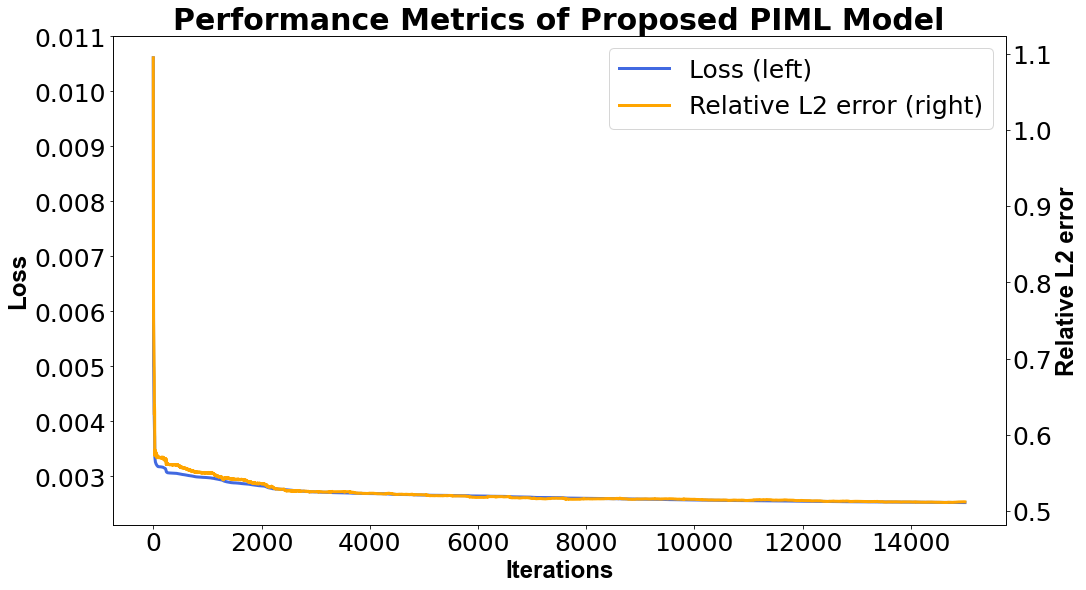

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.020415607344459293
MSE =  0.0027852161431065393
RMSE =  0.05277514702117408
L2 relative error = 0.5035446613957555
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

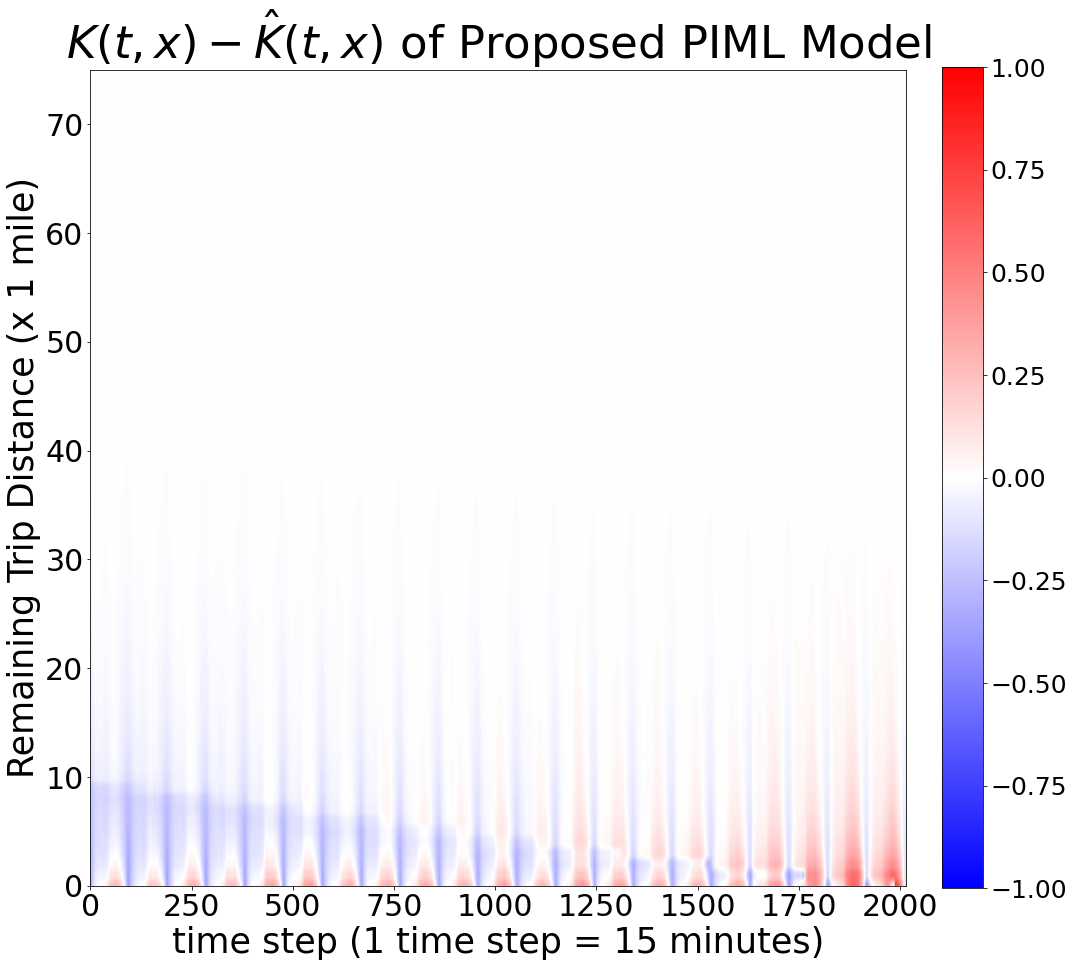

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

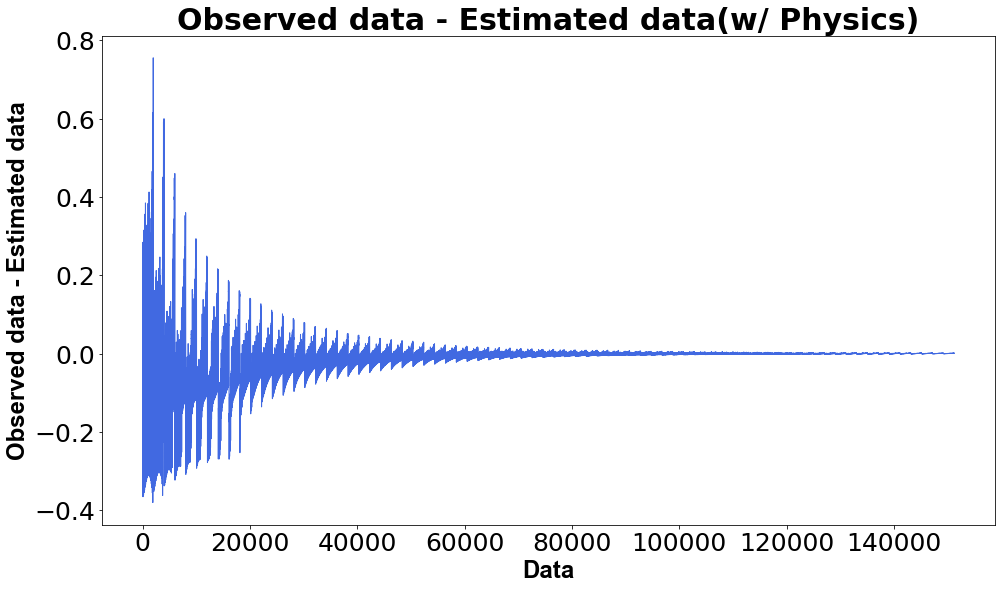

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

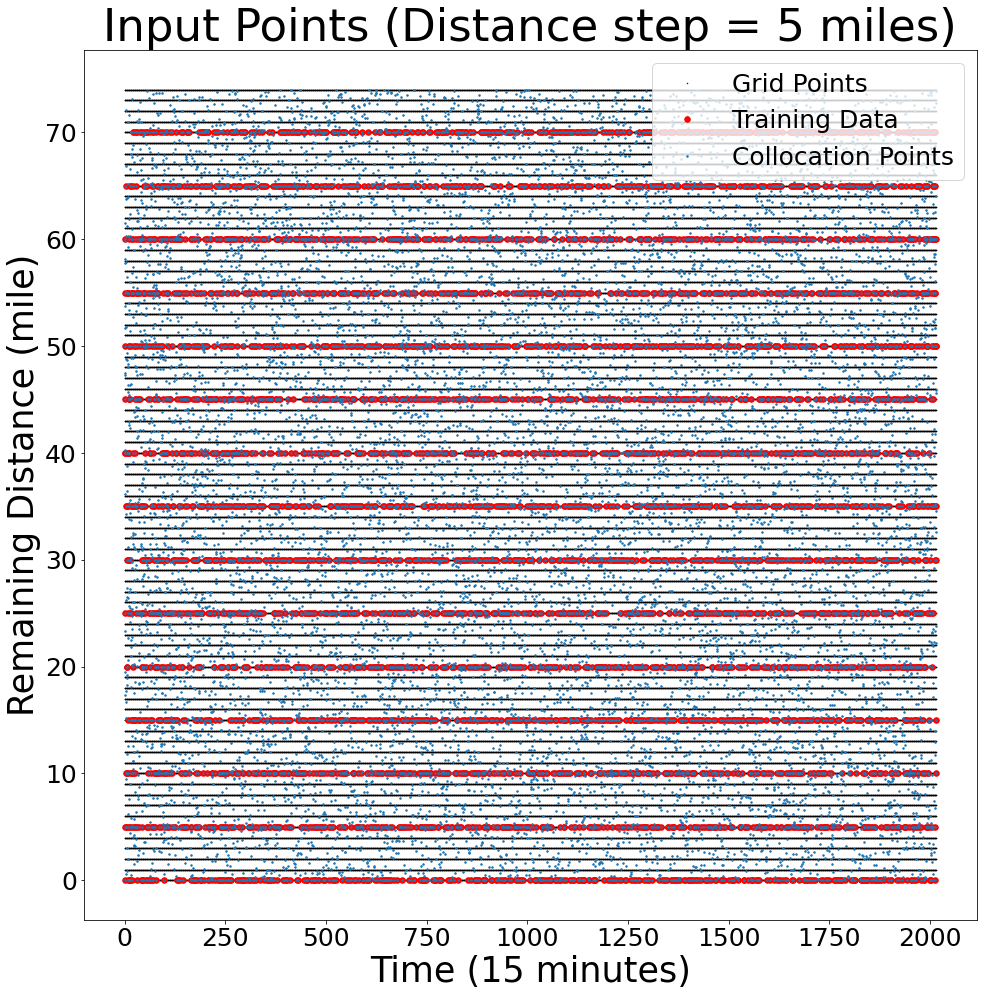

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

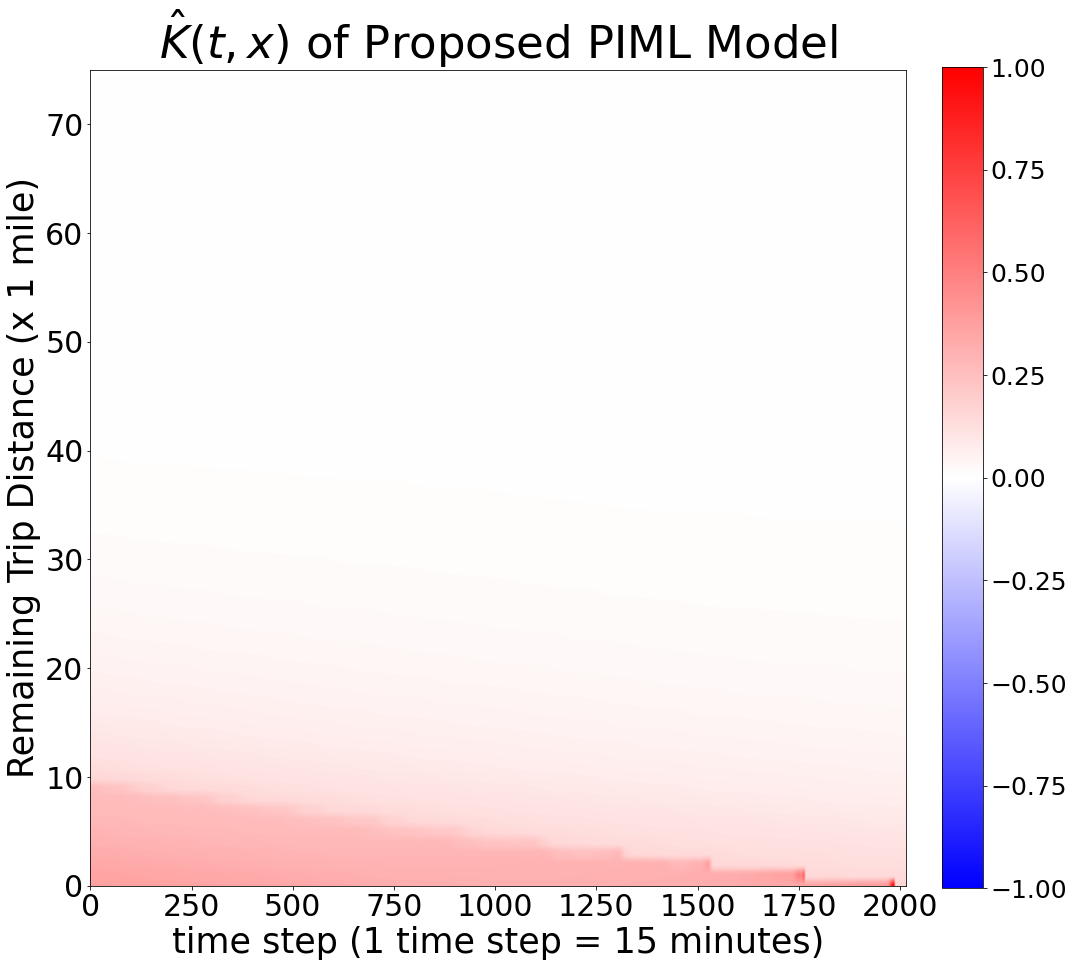

In [22]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)